In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera.p', 'rb'))
OBS = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_TRMM_ERA-I.p', 'rb'))
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA-I.p', 'rb'))

In [4]:
OBS2['hour']

[21,
 18,
 18,
 18,
 20,
 20,
 18,
 18,
 18,
 19,
 18,
 19,
 21,
 20,
 18,
 18,
 18,
 19,
 21,
 18,
 18,
 21,
 20,
 19,
 19,
 18,
 19,
 19,
 20,
 21,
 18,
 20,
 18,
 18,
 19,
 20,
 20,
 19,
 19,
 18,
 18,
 19,
 21,
 21,
 19,
 18,
 18,
 21,
 21,
 20,
 18,
 19,
 19,
 20,
 19,
 21,
 20,
 21,
 18,
 20,
 18,
 19,
 18,
 20,
 18,
 21,
 20,
 19,
 21,
 18,
 20,
 20,
 20,
 20,
 21,
 21,
 18,
 20,
 21,
 18,
 20,
 20,
 18,
 20,
 19,
 18,
 21,
 20,
 21,
 20,
 20,
 19,
 20,
 20,
 20,
 18,
 20,
 19,
 20,
 20,
 19,
 19,
 21,
 19,
 19,
 20,
 19,
 21,
 19,
 19,
 18,
 20,
 21,
 21,
 18,
 19,
 20,
 19,
 19,
 18,
 18,
 19,
 20,
 18,
 19,
 19,
 19,
 19,
 19,
 18,
 20,
 18,
 19,
 20,
 18,
 18,
 18,
 18,
 19,
 19,
 18,
 19,
 19,
 19,
 18,
 20,
 21,
 20,
 18,
 18,
 18,
 18,
 19,
 18,
 20,
 21,
 20,
 21,
 20,
 21,
 19,
 20,
 18,
 21,
 21,
 19,
 18,
 19,
 18,
 18,
 21,
 19,
 21,
 21,
 21,
 20,
 20,
 18,
 19,
 20,
 21,
 18,
 20,
 21,
 19,
 21,
 21,
 18,
 18,
 20,
 21,
 18,
 19,
 19,
 21,
 20,
 20,
 18,
 19,
 19,


In [5]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    
    thetae_up = u_met.theta_e(650,tup-273.15, qup)
    thetae_low = u_met.theta_e(925, tlow-273.15,qq)
    thetae_diff = thetae_low-thetae_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'theta_e' : thetae_diff,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [6]:
obs_trmm = create_dic(OBS)
obs_gpm = create_dic(OBS2)
obs_40 = create_dic(OBS3)

In [7]:
obs_trmm = obs_trmm[(obs_trmm.lon>=-10)&(obs_trmm.lon<=12)&(obs_trmm.lat>=5.2)&(obs_trmm.lat<=8.3)]  #5.2 - 8.3
obs_gpm = obs_gpm[(obs_gpm.lon>=-10)&(obs_gpm.lon<=12)&(obs_gpm.lat>=5.2)&(obs_gpm.lat<=8.3)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=-10)&(obs_40.lon<=12)&(obs_40.lat>=5.2)&(obs_40.lat<=8.3)]


In [8]:
obs_gpm

area       lat        lon  month       prcp      q650       q925  \
0       15175  8.042260   7.086056      7  16.436291  6.616410  14.771931   
1        8625  5.251607  11.170472      8   4.185770  7.055621  16.826462   
2        5050  6.118873  -0.763059     11  25.979994  1.884424  15.512910   
4       12700  5.550144  11.265918      8  16.874041  8.860437  15.085265   
5       13525  5.638003   8.894604      7  37.000000  7.402976  15.771469   
6       10425  6.153120   6.669265      4   2.228098  4.325093  15.239720   
7        5350  7.869163   5.653593      7  10.723988  7.174695  14.604548   
8       10850  5.454751  11.438341      5  14.134404  5.217465  15.294153   
9       10525  5.870359   8.322838      7   1.267474  6.686833  14.475948   
11      12550  7.627684  -2.724923     10   2.670303  5.609727  14.941356   
12      33575  7.870509   3.228624      9  11.288195  6.446645  15.146842   
14     119375  7.307874   1.561593     10  10.609121  6.984177  14.895768   
15      14975  7.451484  11.414791      7  14.001916  6.208157  13.651278   
16      44975  5.399052  -7.269195      7  16.380198  6.930764  15.686756   
17      14600  5.270637   5.290237     11   2.932423  6.646689  15.201617   
18     227525  7.325884  -7.324320      3  46.682351  4.884739  15.806511   
19      15375  6.219792   9.108242      6  26.076926  4.074698  15.568363   
20      32525  7.901187  -9.309505      9  18.112506  4.476827  15.559518   
22      19125  8.136645   3.994759     10  29.911078  4.100555  15.497940   
24       6250  7.605468   9.601770     11   0.134722  5.840390  13.822405   
27      45825  7.551529   1.026177      9  23.284771  5.200114  13.717620   
28      10275  5.348760   7.542300      9   5.046610  5.909112  15.146503   
29      26600  5.980540   2.314716     11  33.672740  6.237416  14.809354   
30      10500  5.651360   8.875902      6  11.874450  6.263271  14.694023   
31      14475  5.940160   7.849684     10  29.610796  5.963886  15.253669   
32      16650  6.465358   9.635330      7   5.810396  8.167088  16.091608   
34      10375  7.816063  -1.352394      3  26.418191  4.425455  16.989082   
36     187825  6.722450   1.689581      5  77.301475  6.305797  16.006555   
37      36575  5.999115   8.504708      9  13.916083  5.347425  15.002934   
38       6000  7.589607   8.261348      3   8.793365  6.782092  16.222589   
...       ...       ...        ...    ...        ...       ...        ...   
19059  157325  6.969307  -0.825743      4  48.693132  7.565937  15.828965   
19060    8950  5.355632   6.355239      7   5.068903  6.429634  15.147863   
19061   65100  5.677011   9.080110      4  24.195806  5.717234  15.995327   
19064   46475  6.808861  -1.113927      7  41.677363  5.449829  13.832270   
19065   60925  6.726726  -8.812060     10  47.340783  6.781412  14.874674   
19066   16775  8.228396  -9.226105      5  19.260493  6.389489  14.787581   
19067   47625  5.958116  -2.265629      6  29.093443  6.961383  15.271700   
19068    8650  6.815028   7.381572     10   9.926799  6.578646  14.797106   
19069   10225  5.843118  11.577737     10  43.357793  4.873852  13.721022   
19070    5900  7.483768   6.707143      9  17.928392  6.621513  14.815819   
19071   72950  7.624389  10.168650      4  24.594280  5.259311  15.966410   
19072   12225  5.311166   6.641291      6  14.684902  6.616750  15.039336   
19075   61425  5.673714  -6.747433      4  34.003214  5.483849  15.857201   
19077    8000  6.382381   9.851335      5   1.282507  6.562997  13.701630   
19078   14300  6.873528   2.083559     10   4.409951  6.681050  14.565764   
19079   53250  7.957489  -8.925624      3  13.271894  4.805810  16.562458   
19080    5425  5.986386   6.280911      9   2.518919  6.639204  14.716477   
19081   19575  5.891634  -7.832145      5   3.631324  7.231170  15.795624   
19083   51650  8.249175  -9.933571      7  43.071406  5.339601  15.252648   
19084   16475  6.917107  -1.831056      9   8.366325  5.991103  14.278286   
19085

In [9]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_trmm', obs_trmm.lat.min(), obs_trmm.lat.max(), obs_trmm.lon.min(), obs_trmm.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 5.202033158482649 8.27489747441562 -9.903745996969064 11.95447649051051
OBS_trmm 5.202948463139375 8.299489120459318 -9.985909169988865 11.952369398805448
OBS_gpm 5.200651754466874 8.299464319878636 -9.999797285878543 11.796071028573365


In [10]:
obs_trmm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'theta_e', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

Text(0.5, 1.0, '-0.53')

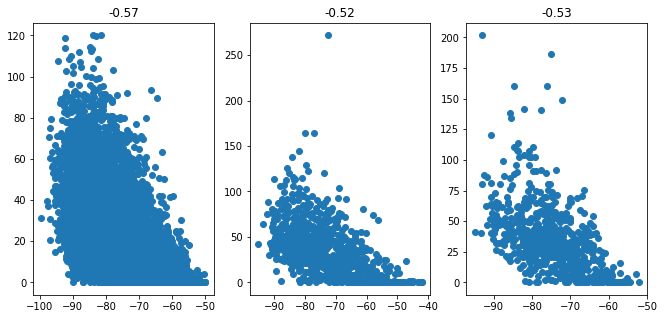

In [88]:
obss = [obs_trmm.tmin, obs_trmm.prcp]
cp4s = [obs_gpm.tmin, obs_gpm.prcp]
cp25s = [obs_40.tmin, obs_40.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [89]:
tl = []
for m in range(2,12):
    try:
        dat = obs_trmm[(obs_trmm.month==m)]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 75)
    except:
        continue
    print(m,out)
    tl.append(out)

3 48.1203250770809
4 49.13789650558766
5 51.59100935992765
6 53.93305802326755
7 51.208678829315254
8 43.944735224048046
9 45.979377222321425
10 47.346190686024386
11 43.86303304587092


In [90]:
pl = []
for m in range(2,12):
    try:
        dat = obs_gpm[obs_gpm.month==m]
        out = np.percentile(np.array(dat['prcp'])[dat['prcp']>1], 98)
    except:
        continue
    print(m,out)
    pl.append(out)

3 66.06542215133743
4 73.06600376704935
5 79.03739515655164
6 76.57629555648349
7 69.08536768565858
8 60.240459254599024
9 64.80215749667416
10 61.56563887655193
11 60.159213875151046


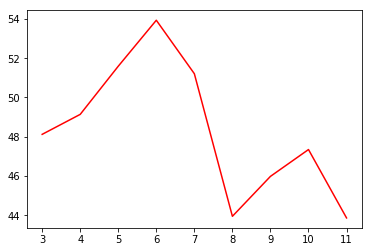

In [91]:
#plt.plot(np.arange(3,12), pl)
plt.plot(np.arange(3,12), tl, 'r')

In [92]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_5-8N_2000-2014_18UTC_front.p', 'rb'))

In [93]:
ts=pd.Series(np.array(era_out['dates']))

In [94]:
ts.dt.month.values

array([ 1,  1,  1, ..., 12, 12, 12])

In [95]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])
ttg = np.array(era_out['tmin'])
ttm = np.array(era_out['tmean'])
lat = np.array(era_out['lat'])
lon = np.array(era_out['lon'])
area = np.array(era_out['area'])

In [96]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : ts.dt.month.values,
    'area' : area*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [97]:
ds = ds[(ds.lon>=-10)&(ds.lon<=12)&(ds.lat>=5)&(ds.lat<=8)]

In [98]:
ds = ds.dropna()

In [99]:
print(ds.lat.max(),ds.lat.min(),ds.lon.max(),ds.lon.min())
print(ds.area.min())
print(obs_trmm.area.min())
print(obs_gpm.area.min())
print(obs_40.area.min())

7.980003356933594 5.004997253417969 9.6300048828125 -9.970001220703125
4921.070000000001
75
4400
1452.0000000000002


In [100]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[(obs_trmm.month == m) & (obs_trmm.prcp>1)],95))
    pgpm.append(np.percentile(obs_gpm.prcp[(obs_gpm.month == m) & (obs_gpm.prcp>1)],95))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[(obs_40.month == m) & (obs_40.prcp>1),95]))
    except:
        ptrmm40.append(np.nan)

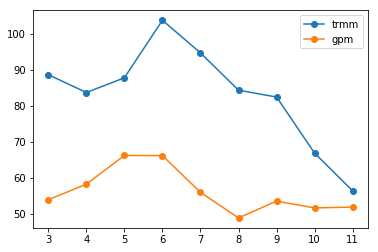

In [101]:
plt.figure()
plt.plot(range(3,12), ptrmm, '-o', label='trmm')
plt.plot(range(3,12), pgpm, '-o',label='gpm')
#plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

In [102]:
ptrmm = []
pgpm = []
ptrmm40 = []
for m in range(3,12):
    
    ptrmm.append(np.sum((obs_trmm.month == m) & (obs_trmm.prcp>60))/np.sum((obs_trmm.month == m) & (obs_trmm.prcp>1)))
    pgpm.append(np.sum((obs_gpm.month == m) & (obs_gpm.prcp>60))/np.sum((obs_gpm.month == m) & (obs_gpm.prcp>1)))
    try:
        ptrmm40.append(np.sum((obs_40.month == m) & (obs_40.prcp>60))/np.sum((obs_40.month == m) & (obs_40.prcp>1)))
    except:
        ptrmm40.append(np.nan)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


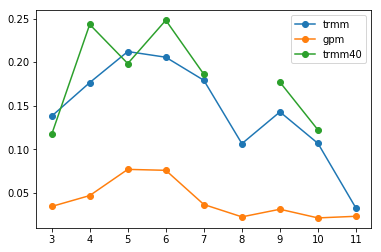

In [103]:
plt.figure()
plt.plot(range(3,12), ptrmm, 'o-',label='trmm')
plt.plot(range(3,12), pgpm, 'o-',label='gpm')
plt.plot(range(3,12), ptrmm40, 'o-',label='trmm40')
plt.legend()

In [104]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.tmin[obs_trmm.month == m],85))
    pgpm.append(np.percentile(obs_gpm.tmin[obs_gpm.month == m],85))
    gridsat.append(np.percentile(ds.tmin[ds.month == m],85))
    try:
        ptrmm40.append(np.percentile(obs_40.tmin[obs_40.month == m],85))
    except:
        ptrmm40.append(np.nan)

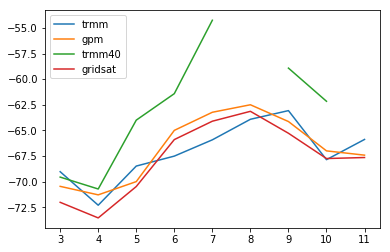

In [105]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.plot(range(3,12), gridsat, label='gridsat')
plt.legend()

In [106]:
ptrmm = []
pgpm = []
ptrmm40 = []
gridsat = []
for m in range(3,12):
    
    ptrmm.append(np.percentile(obs_trmm.prcp[obs_trmm.month == m],99))
    pgpm.append(np.percentile(obs_gpm.prcp[obs_gpm.month == m],99))
    try:
        ptrmm40.append(np.percentile(obs_40.prcp[obs_40.month == m],99))
    except:
        ptrmm40.append(np.nan)

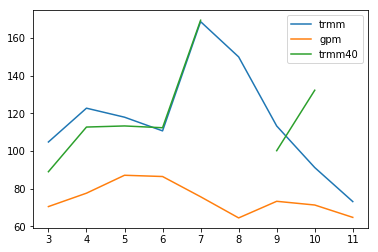

In [107]:
plt.figure()
plt.plot(range(3,12), ptrmm, label='trmm')
plt.plot(range(3,12), pgpm, label='gpm')
plt.plot(range(3,12), ptrmm40, label='trmm40')
plt.legend()

3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
5 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
6 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
7 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
8 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
9 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
10 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
11 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
3 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/__init__.py'>
4 <module 'numpy' from '/home/ck/miniconda3/lib/python3.5/site-packages/numpy/

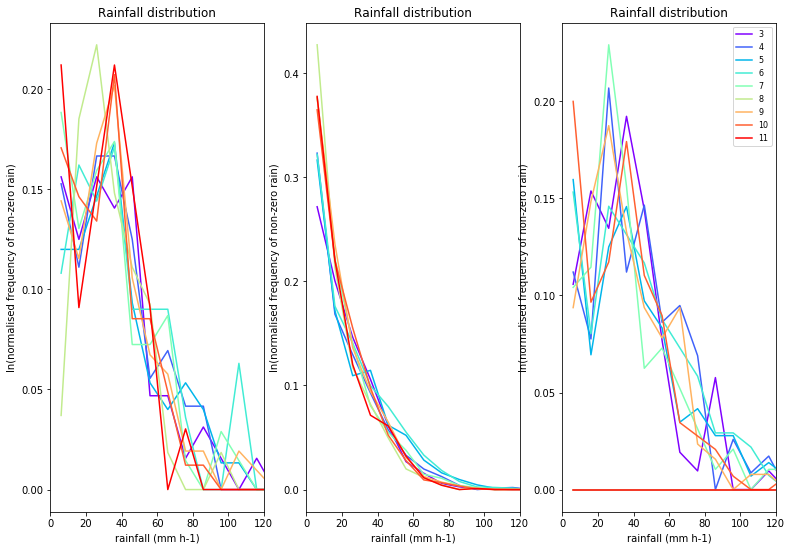

In [108]:
f = plt.figure(figsize=(13,9))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip(np.arange(3,12),colors):
        #print(m)
        
        monthly = (data['prcp'])[data['month'] == m]

        print(m, np)

        #ipdb.set_trace()
        weights = np.ones_like(monthly) / float(len(monthly))
        hist, h = np.histogram(monthly, bins=np.arange(1,201+1,10),  range=(1,201), weights=weights)
        #print(np.arange(20,120+1,10))
        bins=np.arange(1,201+1,10)
        #line, = ax.semilogy(hist, color=c, lw=2, label=str(m))
        mid = bins[1::]-5
        ax.plot(mid,hist, color=c, label=str(m))
    plt.ylabel('ln(normalised frequency of non-zero rain)')
    plt.xlim((0,120))
    plt.xlabel('rainfall (mm h-1)')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


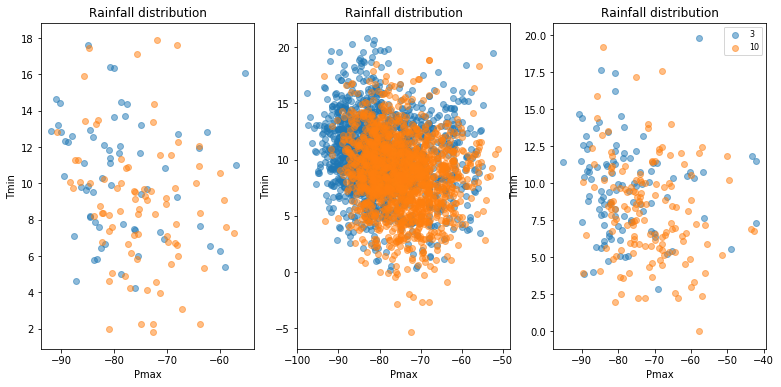

In [109]:
f = plt.figure(figsize=(13,6))

for ids, data in enumerate([obs_trmm, obs_gpm, obs_40]):
    #ipdb.set_trace()
    ax = f.add_subplot(1,3,ids+1)
    colors = cm.rainbow(np.linspace(0,1,9))
    for m,c in zip([3,10],colors):
        #print(m)
#         if m == 5:
        monthly = (data)[data['month'] == m]
#         if m == 9:
        monthly = (data)[data['month'] == m]

        ax.scatter(monthly['tmin'], monthly['shear'], label=str(m), alpha=0.5)
    plt.ylabel('Tmin')
    #plt.xlim((0,120))
    plt.xlabel('Pmax')
    
    plt.title('Rainfall distribution')

plt.legend(fontsize=8)


In [110]:
pos1 = (ds.u650<0) & (ds.area>=5000)# all storms, without trmm overpass - matchup via storm centre points

In [111]:
np.sum(pos1)

11481

In [112]:
oposi = (obs_gpm.u650<0) & (obs_gpm.area>=5000) & (obs_gpm.prcp>=8)# & ((obs_gpm.month>=9) | (obs_gpm.month<=5))

In [113]:
obs_gpm

area       lat        lon  month       prcp      q650       q925  \
0       15175  8.042260   7.086056      7  16.436291  6.616410  14.771931   
1        8625  5.251607  11.170472      8   4.185770  7.055621  16.826462   
2        5050  6.118873  -0.763059     11  25.979994  1.884424  15.512910   
4       12700  5.550144  11.265918      8  16.874041  8.860437  15.085265   
5       13525  5.638003   8.894604      7  37.000000  7.402976  15.771469   
6       10425  6.153120   6.669265      4   2.228098  4.325093  15.239720   
7        5350  7.869163   5.653593      7  10.723988  7.174695  14.604548   
8       10850  5.454751  11.438341      5  14.134404  5.217465  15.294153   
9       10525  5.870359   8.322838      7   1.267474  6.686833  14.475948   
11      12550  7.627684  -2.724923     10   2.670303  5.609727  14.941356   
12      33575  7.870509   3.228624      9  11.288195  6.446645  15.146842   
14     119375  7.307874   1.561593     10  10.609121  6.984177  14.895768   
15      14975  7.451484  11.414791      7  14.001916  6.208157  13.651278   
16      44975  5.399052  -7.269195      7  16.380198  6.930764  15.686756   
17      14600  5.270637   5.290237     11   2.932423  6.646689  15.201617   
18     227525  7.325884  -7.324320      3  46.682351  4.884739  15.806511   
19      15375  6.219792   9.108242      6  26.076926  4.074698  15.568363   
20      32525  7.901187  -9.309505      9  18.112506  4.476827  15.559518   
22      19125  8.136645   3.994759     10  29.911078  4.100555  15.497940   
24       6250  7.605468   9.601770     11   0.134722  5.840390  13.822405   
27      45825  7.551529   1.026177      9  23.284771  5.200114  13.717620   
28      10275  5.348760   7.542300      9   5.046610  5.909112  15.146503   
29      26600  5.980540   2.314716     11  33.672740  6.237416  14.809354   
30      10500  5.651360   8.875902      6  11.874450  6.263271  14.694023   
31      14475  5.940160   7.849684     10  29.610796  5.963886  15.253669   
32      16650  6.465358   9.635330      7   5.810396  8.167088  16.091608   
34      10375  7.816063  -1.352394      3  26.418191  4.425455  16.989082   
36     187825  6.722450   1.689581      5  77.301475  6.305797  16.006555   
37      36575  5.999115   8.504708      9  13.916083  5.347425  15.002934   
38       6000  7.589607   8.261348      3   8.793365  6.782092  16.222589   
...       ...       ...        ...    ...        ...       ...        ...   
19059  157325  6.969307  -0.825743      4  48.693132  7.565937  15.828965   
19060    8950  5.355632   6.355239      7   5.068903  6.429634  15.147863   
19061   65100  5.677011   9.080110      4  24.195806  5.717234  15.995327   
19064   46475  6.808861  -1.113927      7  41.677363  5.449829  13.832270   
19065   60925  6.726726  -8.812060     10  47.340783  6.781412  14.874674   
19066   16775  8.228396  -9.226105      5  19.260493  6.389489  14.787581   
19067   47625  5.958116  -2.265629      6  29.093443  6.961383  15.271700   
19068    8650  6.815028   7.381572     10   9.926799  6.578646  14.797106   
19069   10225  5.843118  11.577737     10  43.357793  4.873852  13.721022   
19070    5900  7.483768   6.707143      9  17.928392  6.621513  14.815819   
19071   72950  7.624389  10.168650      4  24.594280  5.259311  15.966410   
19072   12225  5.311166   6.641291      6  14.684902  6.616750  15.039336   
19075   61425  5.673714  -6.747433      4  34.003214  5.483849  15.857201   
19077    8000  6.382381   9.851335      5   1.282507  6.562997  13.701630   
19078   14300  6.873528   2.083559     10   4.409951  6.681050  14.565764   
19079   53250  7.957489  -8.925624      3  13.271894  4.805810  16.562458   
19080    5425  5.986386   6.280911      9   2.518919  6.639204  14.716477   
19081   19575  5.891634  -7.832145      5   3.631324  7.231170  15.795624   
19083   51650  8.249175  -9.933571      7  43.071406  5.339601  15.252648   
19084   16475  6.917107  -1.831056      9   8.366325  5.991103  14.278286   
19085

In [114]:
ds_march = ds[pos1]
obsp = obs_gpm[oposi]

In [115]:
obsp.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'theta_e', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

In [116]:
len(obsp)

9001

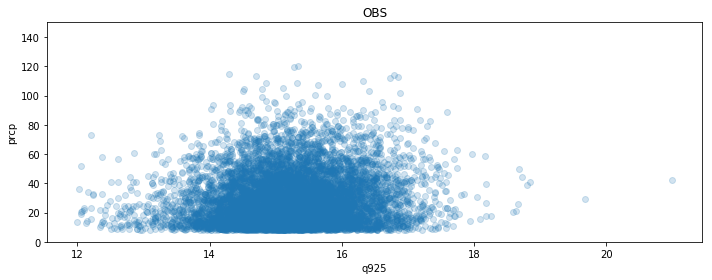

In [117]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).q925, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

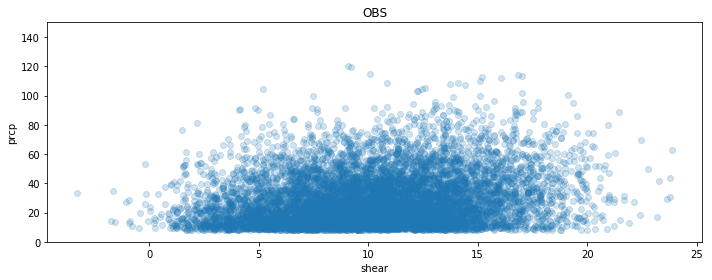

In [118]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obsp.q925>12
plt.scatter(obsp.where(isqq).shear, obsp.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

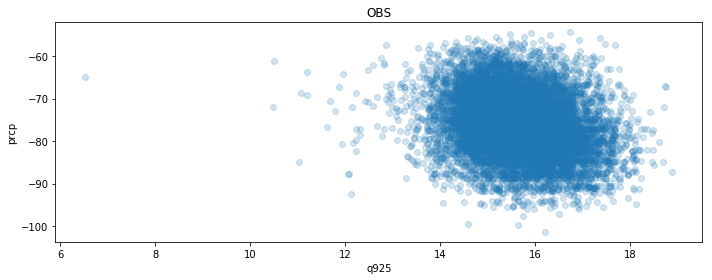

In [119]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
plt.scatter(ds_march.q925, ds_march.tmin, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
#ax.set_ylim(0,150)
plt.tight_layout()

In [120]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    rr = stats.pearsonr(v1,v2)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

pears (-0.1960685962289198, 3.3404579051898193e-125)
(-0.18579197403239917, 2.1594922239295758e-112)


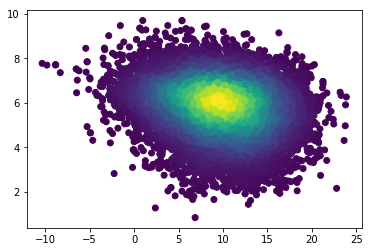

In [121]:
data, r = density_plot(obs_gpm['shear'], obs_gpm['q650'], obs_gpm['q925'])
print(u_stat.pcor(obs_gpm['shear'], obs_gpm['q650'], obs_gpm['q925']))
plt.scatter(obs_gpm['shear'], obs_gpm['q650'], c=data)

pears (0.22312882419591146, 1.702575380605353e-162)
(0.21426275914850404, 1.09268318562256e-149)


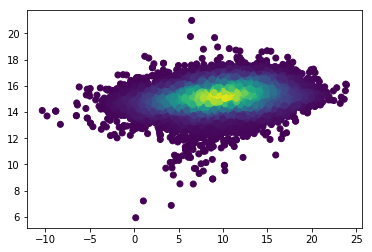

In [122]:
data, r = density_plot(obs_gpm['shear'], obs_gpm['q925'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'], obs_gpm['q925'], obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.06898282573599594, 1.0233444326624354e-16)
(-0.026399311904601402, 0.0015045686147516664)


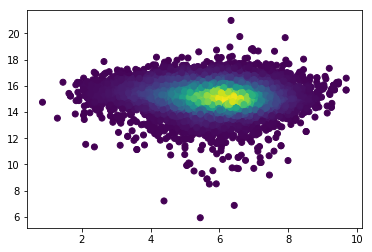

In [123]:
data, r = density_plot(obs_gpm['q650'], obs_gpm['q925'], obs_gpm['shear'])
print(u_stat.pcor(obs_gpm['q650'], obs_gpm['q925'], obs_gpm['shear']))
plt.scatter(obs_gpm['q650'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

In [124]:
thetae_up = u_met.theta_e(650,obs_gpm['t650'], obs_gpm['q650']/1000)
thetae_low = u_met.theta_e(925, obs_gpm['t925'], obs_gpm['q925']/1000)
thetae_diff = thetae_low-thetae_up

In [125]:
theta_up = u_met.theta(650,obs_gpm['t650'])
theta_low = u_met.theta(925, obs_gpm['t925'])
theta_diff = theta_low-theta_up

pears (-0.2922356447138319, 1.7603801692742297e-282)
(-0.27207174430334946, 1.23021568272737e-243)


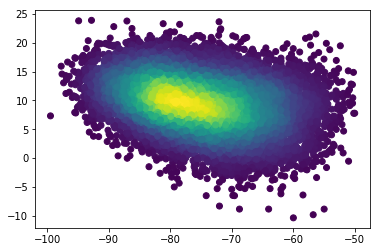

In [126]:
data, r = density_plot(obs_gpm['tmin'],obs_gpm['shear'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],obs_gpm['shear'], obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], obs_gpm['shear'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.2179106773885719, 6.78947429667667e-155)
(-0.1853276618249806, 7.85893543002073e-112)


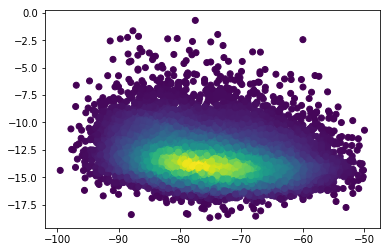

In [127]:
data, r = density_plot(obs_gpm['tmin'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.3002695432405071, 7.24929231902603e-299)
(-0.3226825722343638, 0.0)


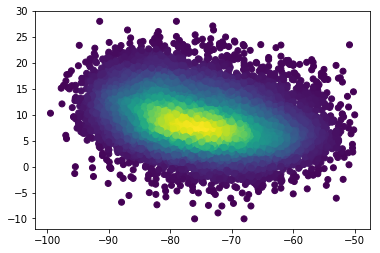

In [128]:
data, r = density_plot(obs_gpm['tmin'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['tmin'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['tmin'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.15054944878212773, 5.087852675656342e-74)
(0.09851851483557819, 1.6745231490771777e-32)


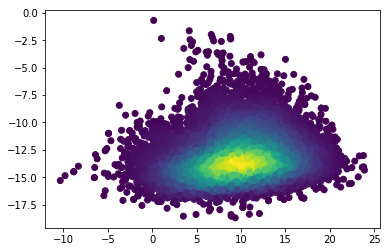

In [129]:
data, r = density_plot(obs_gpm['shear'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.30288181306608386, 2.6184570448278784e-304)
(0.2536808027823449, 5.163713801322633e-211)


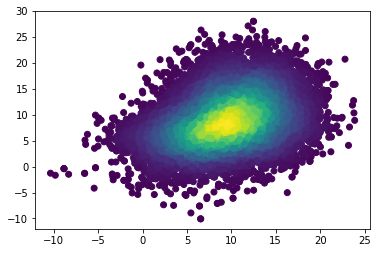

In [130]:
data, r = density_plot(obs_gpm['shear'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['shear'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['shear'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.1960685962289198, 3.3404579051898193e-125)
(-0.18579197403239917, 2.1594922239295758e-112)


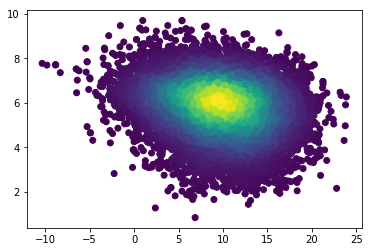

In [131]:
data, r = density_plot(obs_gpm['shear'],obs_gpm['q650'], obs_gpm['q925'])
print(u_stat.pcor(obs_gpm['shear'],obs_gpm['q650'], obs_gpm['q925']))
plt.scatter(obs_gpm['shear'], obs_gpm['q650'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (-0.03092939570141377, 0.00020017872687481012)
(-0.025544263159933193, 0.0021336432441624274)


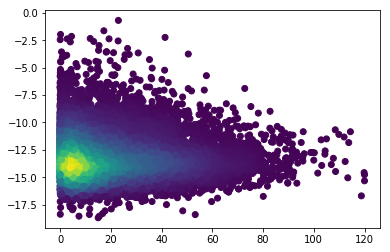

In [132]:
data, r = density_plot(obs_gpm['prcp'],theta_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],theta_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['prcp'], theta_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.01623640797835819, 0.05095678895234611)
(0.06024008774739163, 4.2435922780739574e-13)


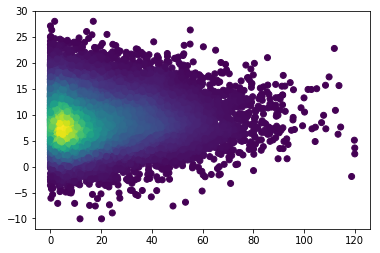

In [133]:
data, r = density_plot(obs_gpm['prcp'],thetae_diff, obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],thetae_diff, obs_gpm['q650']))
plt.scatter(obs_gpm['prcp'], thetae_diff, c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.18840448560857145, 1.3864997440242262e-115)
(0.1953801482149091, 2.5887196903123905e-124)


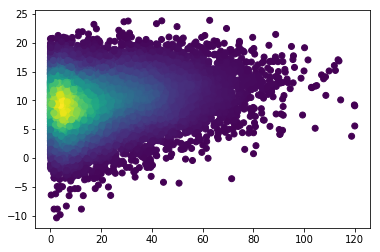

In [134]:
data, r = density_plot(obs_gpm['prcp'],obs_gpm['shear'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],obs_gpm['shear'], theta_diff))
plt.scatter(obs_gpm['prcp'], obs_gpm['shear'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

pears (0.08807173940633943, 2.753795154798542e-26)
(0.08424085020143336, 3.525651831986446e-24)


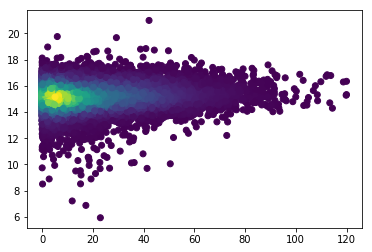

In [135]:
data, r = density_plot(obs_gpm['prcp'],obs_gpm['q925'], obs_gpm['q650'])
print(u_stat.pcor(obs_gpm['prcp'],obs_gpm['q925'], theta_diff))
plt.scatter(obs_gpm['prcp'], obs_gpm['q925'], c=data)

#this is at storm time. Remember, March has higher low-level q values than October on storm days!

In [136]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(8, 8), dpi=100)
    cc=11
    ax1 = fig.add_subplot(321)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('shear')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(322)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('Partial correlation | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(323)

    data3, r3 = density_plot(dat.shear, dat.prcp, dat.q925)

    mappable = ax2.scatter(dat.shear, dat.prcp, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(13, 18)
    ax2.set_ylabel('prcp')
    ax2.set_xlabel('shear')
    ax2.set_title('Partial correlation | q925 removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(324)

    data4, r4 = density_plot(dat.q925, dat.prcp, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.prcp , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('prcp')
    ax2.set_xlabel('q925')
    ax2.set_title('Partial correlation | shear removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')
    
        ####################################################################################
    ax2 = fig.add_subplot(325)

    data4, r4 = density_plot(dat.shear, dat.q925, dat.q650)

    mappable = ax2.scatter(dat.shear, dat.q925 , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_ylim(11, 20)
    ax2.set_ylabel('q925')
    ax2.set_xlabel('shear')
    ax2.set_title('Partial correlation | q650 removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')
    
        ####################################################################################
    ax2 = fig.add_subplot(326)

    data4, r4 = density_plot(dat.shear, dat.theta_e, dat.q650)

    mappable = ax2.scatter(dat.shear, dat.theta_e , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('theta_e')
    ax2.set_title('Partial correlation | q650 removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [137]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(11, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    #ax2.set_xlim(13, 20)
    ax2.set_ylabel('q925')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

In [138]:
ds_march.keys()

Index(['area', 'lat', 'lon', 'month', 'q700', 'q925', 'shear', 'tmean', 'tmin',
       'u650', 'u925'],
      dtype='object')

pears (-0.29054319818015706, 1.3289623522792369e-174)
pears (-0.29743079129672123, 2.824685546676784e-183)
pears (0.21369314858324542, 1.813460273213275e-93)
pears (0.10949474192208218, 2.0510772169706503e-25)
pears (0.18135715192219234, 2.0546698168283207e-67)
pears (0.2558390110383988, 1.717071042203711e-134)


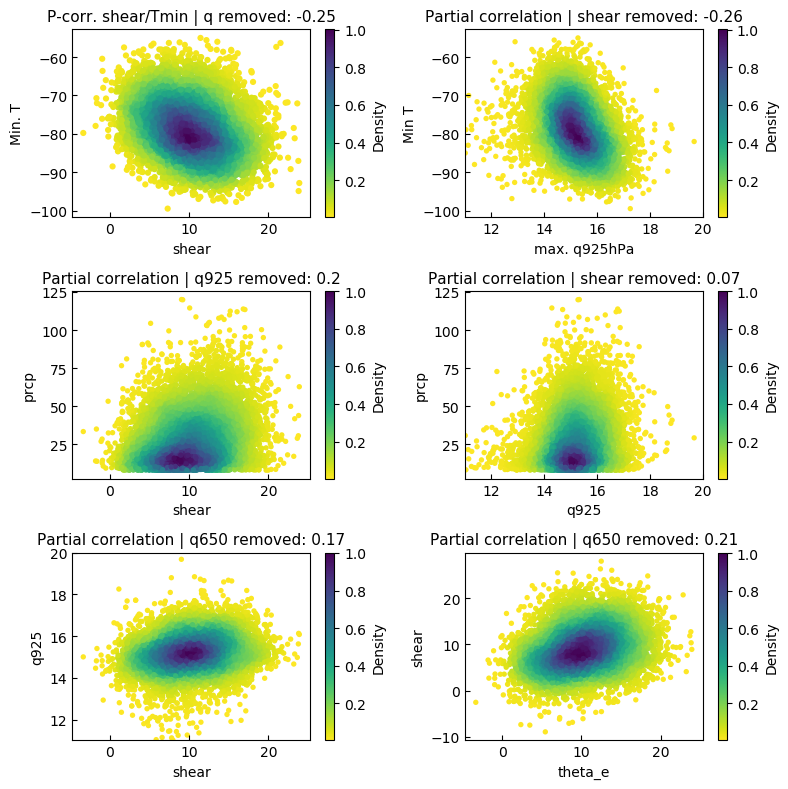

In [139]:
plot_scatter_month(obsp)

In [140]:
print(obsp['q925'].median())
print(obsp['shear'].median())
print(obsp['prcp'].median())
print(obsp['tmin'].median())
print(obsp['theta_e'].median())

15.185626223683357
10.122456550598145
23.800592756825363
-79.07481270550745
8.725775378534081


In [141]:
print(obsp['q925'].mean())
print(obsp['shear'].mean())
print(obsp['prcp'].mean())
print(obsp['tmin'].mean())
print(obsp['theta_e'].mean())

15.189353135958564
10.187003208946988
28.538127973725956
-78.79063409910967
9.068216698882008


In [142]:
np.percentile(obsp['q925'],99)

17.256146296858788

In [143]:
print(obsp['theta_e'][(obsp['q925']<=14) & (obsp['shear']>=15) & (obsp['prcp']>=20)].mean())

6.732040482608606


In [144]:
print(len(obsp['theta_e'][(obsp['q925']<=14) & (obsp['shear']>=15) & (obsp['prcp']>=17)]))

43


In [145]:
print(obsp['theta_e'][(obsp['q925']<=14) & (obsp['shear']>=15) & (obsp['prcp']>=17)].median())

5.928481879340723


pears (-0.29054319818015706, 1.3289623522792369e-174)
pears (-0.29743079129672123, 2.824685546676784e-183)
pears (0.21369314858324542, 1.813460273213275e-93)
pears (0.10949474192208218, 2.0510772169706503e-25)
pears (0.18135715192219234, 2.0546698168283207e-67)
pears (0.2558390110383988, 1.717071042203711e-134)


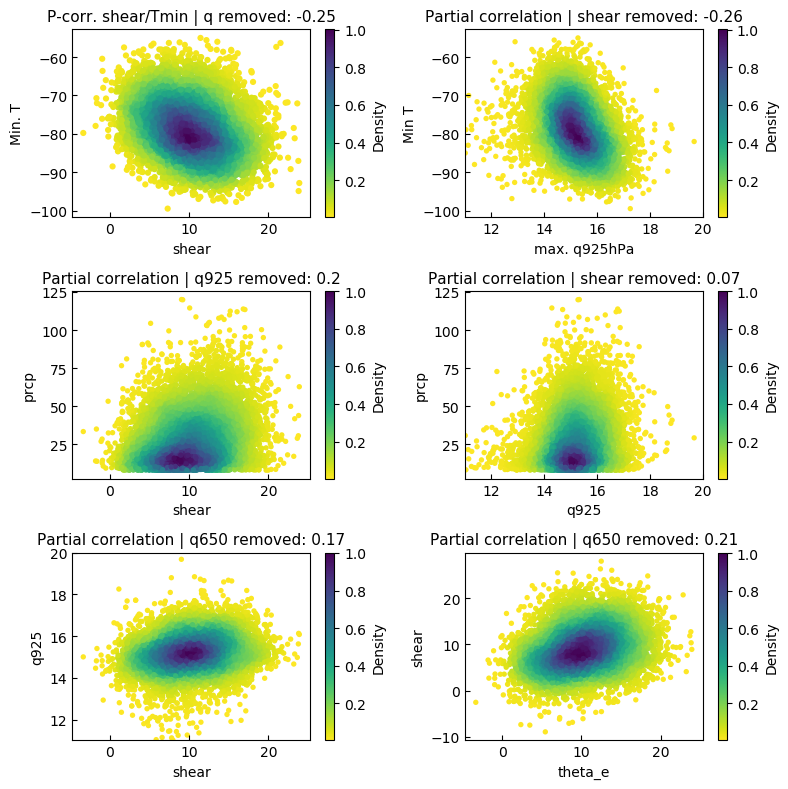

In [146]:
plot_scatter_month(obsp)

In [72]:
alln=7
nbs= alln
nbq= alln
nba = alln

p1 = 1 #5
p2 = 99

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=np.percentile(ds_march.shear,p1)) & (ds_march.shear<=np.percentile(ds_march.shear,p2))], np.linspace(0,100,nbs)) #np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))

# shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
# shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=20)], np.linspace(0,100,nbs))
# shear25_march = np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(np.percentile(ds_march.q925, 2) , np.percentile(ds_march.q925, p2), nbq) 

nbqq = 9
nbss = 9

p1 = 1
p2 = 99

#shear_obsp = np.percentile(obsp.shear[(obsp.shear>=np.percentile(obsp.shear,p1)) & (obsp.shear<=np.percentile(obsp.shear,p2))], np.linspace(0,100,nbss)) # np.percentile(cp25_march.shear[(cp4_march.shear>=8) & (cp25_march.shear<=20)], np.linspace(0,100,nbs))
#np.percentile(obsp.shear[(obsp.shear>=3) & (obsp.shear<=17)], np.linspace(0,100,nbss))

qbinso = np.linspace(np.percentile(obsp.q925, p1) , np.percentile(obsp.q925, p2), nbqq)
shear_obsp = np.linspace(np.percentile(obsp.shear, p1) , np.percentile(obsp.shear, p2), nbss)


In [73]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.nanmean(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mean = np.nanmean(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
            except:
                prcp_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 50)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outarea_ds, outval

In [74]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<10] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [75]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [76]:
def hist2d_six(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,3,i+1)
        if i>2:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_pcp.png')

In [77]:
def hist2d_three(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,4))
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,3,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)

    plt.tight_layout() 
    plt.savefig(cnst.network_data + 'figs/CLOVER/fig3_obsOnly.png')

In [78]:
dsperc_mar, dsp_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)

In [79]:
cpobsperc, pcobs, obsarea, obsval = create_2dhist(obsp, shear_obsp, qbinso)

/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


In [80]:
print(ds_march.shear.mean())
print(ds_march.q925.mean())

10.781728921405445
15.630504314872617


In [81]:
print(len(obsp))

9001


In [191]:
# tmin_dic = {
#     'data' : dsperc_mar,
#     'ybins' : qbinsb_march,
#     'xbins' : shearb_march,
#     'title' : 'Median minimum temperature',
#     'valid' : dsval_mar,
#     'cbarlabel' : '${\circ}$C',
#     'vmin' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],1),
#     'vmax' : np.percentile(dsperc_mar[(dsperc_mar!=0) & np.isfinite(dsperc_mar)],99),
#     'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
#     'xlabel' : 'Wind shear (m s$^{-1}$)'
# }


tmin_dic = {
    'data' : cpobsperc,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average minimum temperature',
    'valid' : obsval,
    'cbarlabel' : '${\circ}$C',
    'vmin' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],1),
    'vmax' : np.percentile(cpobsperc[(cpobsperc!=0) & np.isfinite(cpobsperc)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

pcobs[pcobs==0]=np.nan
prcp_dic = {
    'data' : pcobs,
    'ybins' : qbinso,
    'xbins' : shear_obsp,
    'title' : 'Average maximum precipitation',
    'valid' : obsval,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],1),
    'vmax' : np.percentile(pcobs[(pcobs!=0) & np.isfinite(pcobs)],99),
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

area_dic = {
    'data' : dsarea_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'Observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],1),
    'vmax' : np.percentile(dsarea_mar[(dsarea_mar!=0) & np.isfinite(dsarea_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [86]:
shearscat = np.repeat(shear_obsp,pcobs.shape[0],axis=0).reshape(pcobs.shape)

In [148]:
deltaPS = []
deltaQPS = []
sboxplot = []
tminbox = []
for sh in np.unique(shearscat):
        
        vals = pcobs[sh==shearscat]
        tvals = cpobsperc[sh==shearscat]
        deltaPS.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPS.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPS.append(np.nan)
        sboxplot.append(vals)
        tminbox.append(tvals)
print(np.median(np.array(deltaQPS)[np.isfinite(np.array(deltaQPS))]))

2.8140765475529577


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


9
9


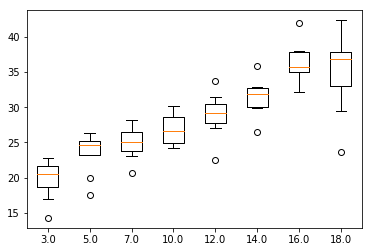

In [149]:
scoll = []
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
for b in sboxplot:
    scoll.append(b[np.isfinite(b)])
print(len(scoll))
print(len(np.unique(shearscat)))
ax = plt.boxplot(scoll[0:-1], labels=scollbins, whis=1)
box1= (scoll[0:-1],scollbins)

/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


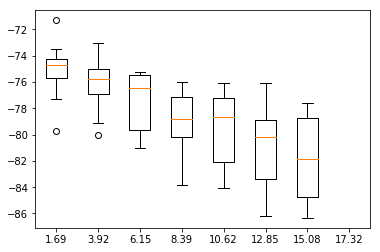

In [150]:
coll = []
for b in tminbox:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(shearscat),2)[0:-1])

1.030155557809148
0.8419151314658406


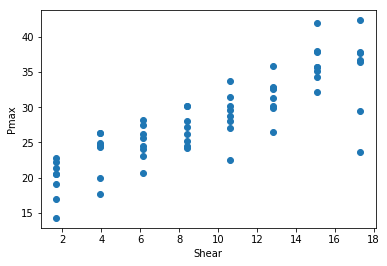

In [151]:
plt.scatter(shearscat, pcobs)
plt.xlabel('Shear')
plt.ylabel('Pmax')
shearfin = shearscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
slope, intercept, r_value, p_value, std_err = stats.linregress(shearfin, pfin)
print(slope)
print(r_value)

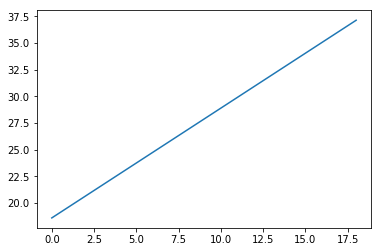

In [152]:
plt.plot(intercept+slope*range(19))

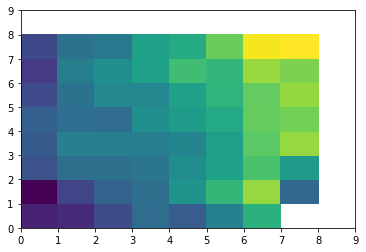

In [153]:
plt.pcolormesh(pcobs.T)

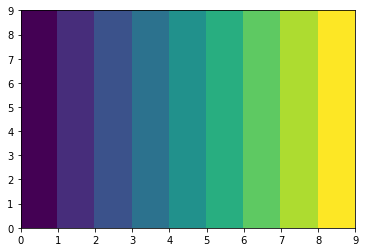

In [154]:
plt.pcolormesh(shearscat.T)

In [155]:
plt.pcolormesh(qscat.T)

NameError: name 'qscat' is not defined

1.8959514100744204
0.3994458821188345


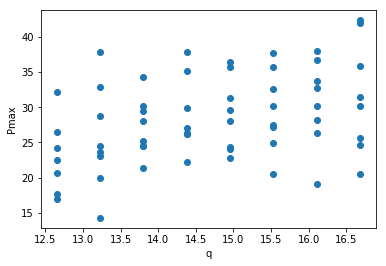

In [156]:
qscat = np.repeat(qbinso[np.newaxis,:],pcobs.shape[0],axis=0).reshape(pcobs.shape)
plt.scatter(qscat, pcobs)
plt.xlabel('q')
plt.ylabel('Pmax')
qfin = qscat[np.isfinite(pcobs)]
pfin = pcobs[np.isfinite(pcobs)]
qslope, qintercept, qr_value, qp_value, qstd_err = stats.linregress(qfin, pfin)
print(qslope)
print(qr_value)

In [157]:
deltaPQ = []
deltaQPQ = []
boxplotq = []
tminboxq = []
for qr in np.unique(qscat):
        
        vals = pcobs[qr==qscat]
        tvals = cpobsperc[qr==qscat]
        deltaPQ.append(np.nanmax(vals)-np.nanmin(vals))
        try:
            deltaQPQ.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
        except:
            deltaQPQ.append(np.nan)
        boxplotq.append(vals)
        tminboxq.append(tvals)
print(np.median(np.array(deltaQPQ)[np.isfinite(np.array(deltaQPQ))]))

6.748820523914061


/home/ck/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: All-NaN slice encountered
  if __name__ == '__main__':


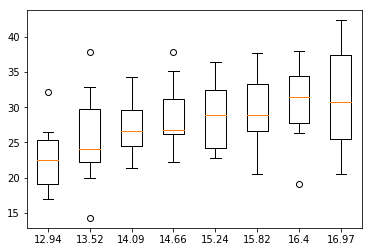

In [158]:
coll = []
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
for b in boxplotq:
    coll.append(b[np.isfinite(b)])
ax = plt.boxplot(coll[0:-1], labels=qcollbins, whis=1)
box2= (coll[0:-1],qcollbins)

/home/ck/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/ck/miniconda3/lib/python3.5/site-packages/matplotlib/cbook/__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


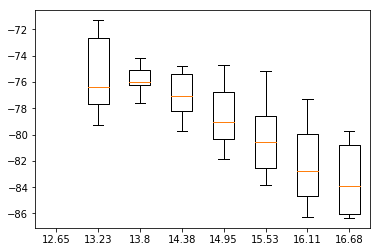

In [159]:
coll = []
for b in tminboxq:
    coll.append(b[b!=0])
ax = plt.boxplot(coll[0:-1], labels=np.round(np.unique(qscat),2)[0:-1])

In [160]:
print(qslope)
print(slope)

1.8959514100744204
1.030155557809148


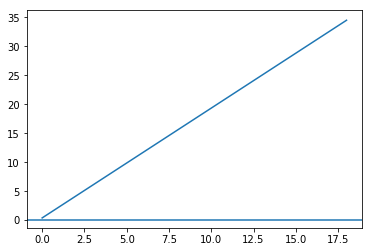

In [161]:
plt.plot(qintercept+qslope*range(19))
plt.axhline(0)

In [200]:
sensitivity = {}
sensitivity['shear_slope'] = slope
sensitivity['qslope'] = qslope 
pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

(array([  50.,  496., 1628., 2853., 2936., 2104., 1029.,  311.,   69.,
           5.]),
 array([-1.8368516 ,  1.10604668,  4.04894495,  6.99184322,  9.9347415 ,
        12.87763977, 15.82053804, 18.76343632, 21.70633459, 24.64923286,
        27.59213114]),
 <a list of 10 Patch objects>)

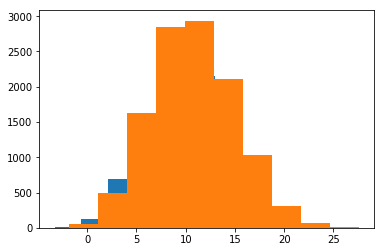

In [163]:
plt.hist(obsp.shear)
plt.hist(ds_march.shear)

In [164]:
data_list = [tmin_dic, prcp_dic, area_dic]

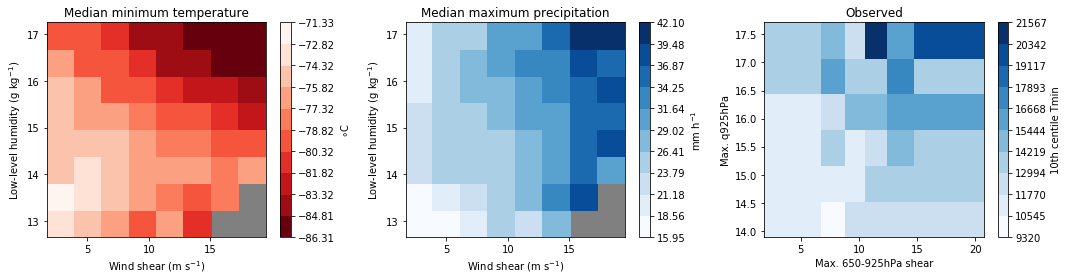

In [165]:
hist2d_three(data_list, valid=True)

99 percentile precip >1 62.79678667331696
[ 2.61768603  5.39413189  6.98467072  8.11978771  9.18811218 10.19189358
 11.18055248 12.34996937 13.54583931 15.28164608 19.56861343]
bigger than 2.6176860332489014
smaller than 5.394131889343262
bigger than 5.394131889343262
smaller than 6.984670715332032
bigger than 6.984670715332032
smaller than 8.119787712097168
bigger than 8.119787712097168
smaller than 9.18811218261719
bigger than 9.18811218261719
smaller than 10.191893577575684
bigger than 10.191893577575684
smaller than 11.18055248260498
bigger than 11.18055248260498
smaller than 12.349969367980957
bigger than 12.349969367980957
smaller than 13.545839309692383
bigger than 13.545839309692383
smaller than 15.28164608001709
bigger than 15.28164608001709
smaller than 19.568613433837918


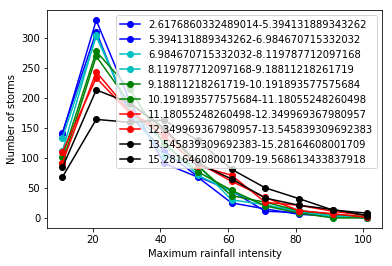

In [166]:
p = np.array(obsp.shear)
t = np.array(obsp.prcp)
q = np.array(obsp.q925)

print('99 percentile precip >1', np.percentile(t[t>1],95))


bins = np.percentile(p[p>=2], np.linspace(1,99,11))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>=58) / np.sum(t[pos]>=1)*100
    qprob = np.sum(q[pos]>=17.5) / np.sum(q[pos]>=12)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

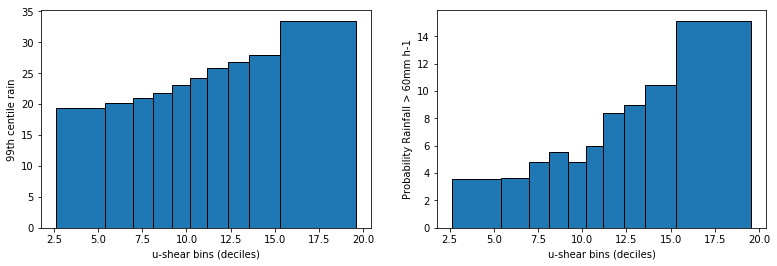

In [167]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

bar_dic = {
'xtick' : xtick,
'ytick' : pprob,
'width' : xtickwidth
}

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

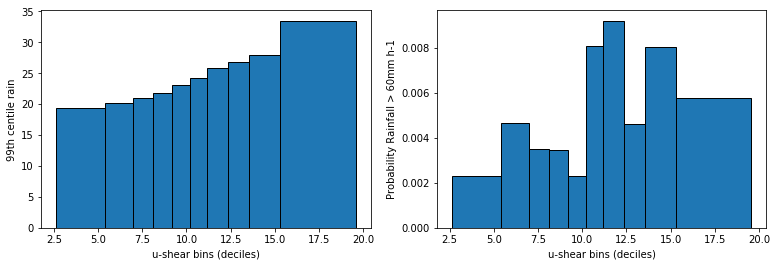

In [168]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

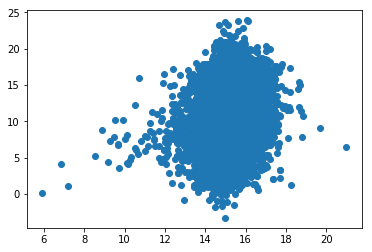

In [169]:
plt.scatter(obsp.q925, obsp.shear)

In [170]:
np.percentile(obsp.prcp[obsp.prcp>1],90)

53.29770259387563

[13.00113648 14.28936174 14.62703902 14.87762326 15.0961522  15.32137021
 15.5442087  15.83981452 16.24942695 20.99131607]
bigger than 13.001136481761932
smaller than 14.289361735184986
bigger than 14.289361735184986
smaller than 14.627039018604492
bigger than 14.627039018604492
smaller than 14.877623257537682
bigger than 14.877623257537682
smaller than 15.096152201294899
bigger than 15.096152201294899
smaller than 15.321370214223862
bigger than 15.321370214223862
smaller than 15.544208697974682
bigger than 15.544208697974682
smaller than 15.839814518888792
bigger than 15.839814518888792
smaller than 16.24942695101102
bigger than 16.24942695101102
smaller than 20.991316065192223


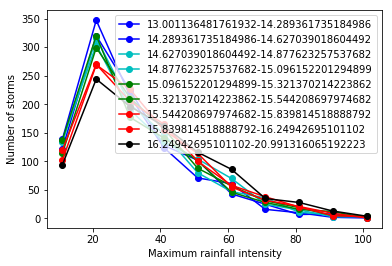

In [171]:
p = np.array(obsp.q925)
t = np.array(obsp.prcp)
q = np.array(obsp.shear)


bins = np.percentile(p[p>=13], np.linspace(0,100,10))#np.arange(4, 29, 2)  # compute probability per temperature range (1degC)
print(bins)
shearlist = []
pprob = []
qqprob = []
plist = []
#ax5 = fig.add_subplot(236)

colours = [ 'b', 'b',  'c', 'c', 'g', 'g', 'r', 'r', 'k', 'k']

for ids, c in enumerate(bins[0:-1]):
    pos = np.where((p >= c) & (p < bins[ids+1]))
    print('bigger than',c )
    print('smaller than', bins[ids+1])

    try:
        cmean = np.percentile(t[pos], 50)
    except IndexError:
        cmean = np.nan

    H, binz = np.histogram(t[pos], bins=np.arange(1,111,10))
    #H, bins = ustat.histo_frequency(t[pos])

    plt.plot(binz[0:-1]+(binz[1::]-binz[0:-1]), H, 'o-',  label=str(c)+'-'+str(bins[ids+1]) , color=colours[ids])

    prob = np.sum(t[pos]>55) / np.sum(t[pos]>1)
    qprob = np.sum(q[pos]>=18) / np.sum(q[pos]>=0)
    pprob.append(prob)
    qqprob.append(qprob)
    plist.append(cmean)
    shearlist.append(((bins[ids+1])-c)/2)

plt.xlabel('Maximum rainfall intensity')
plt.ylabel('Number of storms')
plt.plot()
plt.legend()
xtick = bins[0:-1]

xtickwidth= (bins[1::]-bins[0:-1])

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

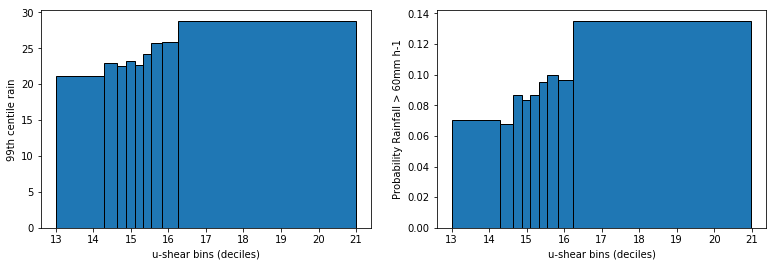

In [172]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, pprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

Text(0, 0.5, 'Probability Rainfall > 60mm h-1')

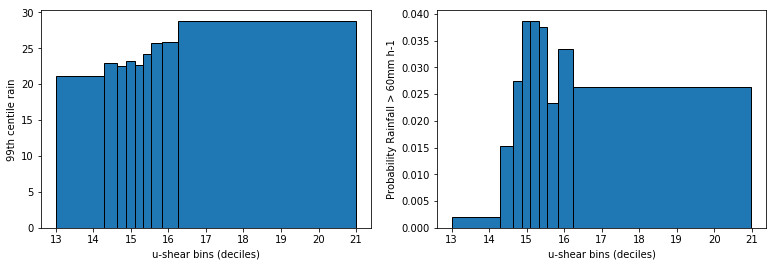

In [173]:
f = plt.figure(figsize=(13,4))
ax4 = f.add_subplot(121)

ax4.bar(xtick, plist, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('99th centile rain')

ax4 = f.add_subplot(122)

ax4.bar(xtick, qqprob, xtickwidth, align='edge', ec='black')
ax4.set_xlabel('u-shear bins (deciles)')
ax4.set_ylabel('Probability Rainfall > 60mm h-1')

In [174]:
u_stat.pcor(obsp.prcp, obsp.q925,obsp.shear)

(0.0736336778585011, 2.67102019048867e-12)

In [175]:
u_stat.pcor(obsp.prcp, obsp.shear,obsp.q925)

(0.19829629223114492, 1.7590403884818132e-80)

In [176]:
def sort_vars():
    q925 = np.array(obsp.shear)
    shears = np.array(obsp.q925)

    sort = np.argsort(q925)
    q = q925[sort]

    shear = shears[sort]
    tmin = np.array(obsp.prcp)[sort]
    
    linsp = np.linspace(0,len(q925)-1,12)
    #linsp = np.percentile(q925[q925>=2], np.linspace(0,99,11))
    
    inds = np.round(linsp).astype(int)

    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qsample = q[inds[start]:end]
        qmean.append( np.min(qsample)+ (np.max(qsample)-np.min(qsample))/2)
        
            

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])
        print(shear[inds[start]], shear[end])
#         ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
#         corr.append(ttslope) 
        corr.append(rc)
        qcorr.append(ttslope) 
    return qmean, corr, qcorr

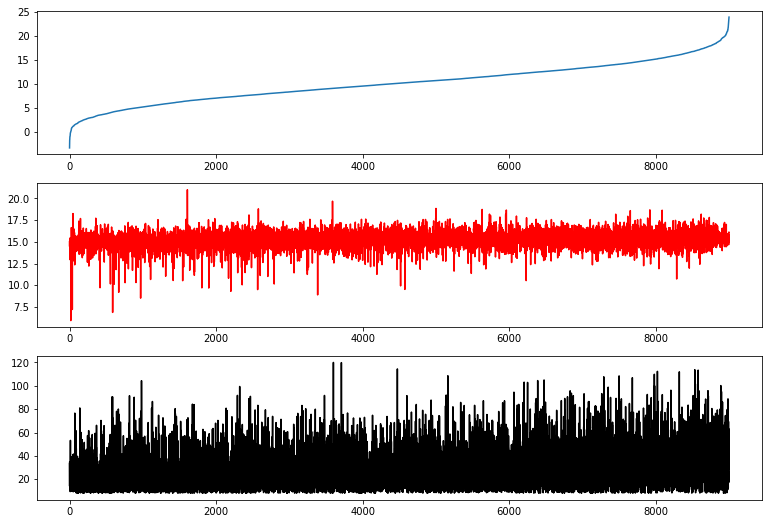

15.002934262156487 14.902232214808464
15.540465712547302 15.87115041911602
14.902232214808464 15.334298834204674
15.87115041911602 15.310823917388916
15.334298834204674 15.031851828098297
15.310823917388916 14.94509819895029
15.031851828098297 13.779537752270699
14.94509819895029 15.522094443440437
13.779537752270699 15.576869249343872
15.522094443440437 16.07629656791687


In [177]:
qmean, corr, slope = sort_vars()

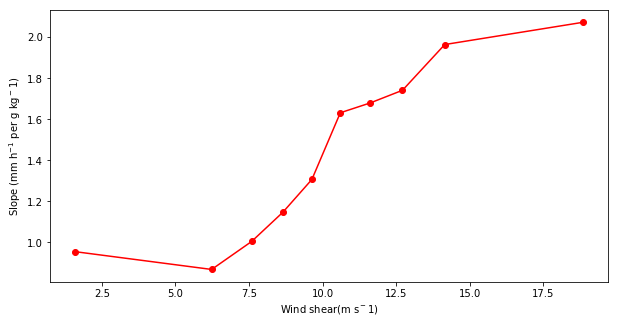

In [178]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,slope, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
slope_dic = {
'xtick' : qmean,
'ytick' : slope,
}

Text(0, 0.5, 'Slope (mm h$^{-1}$ per g kg$^-1$)')

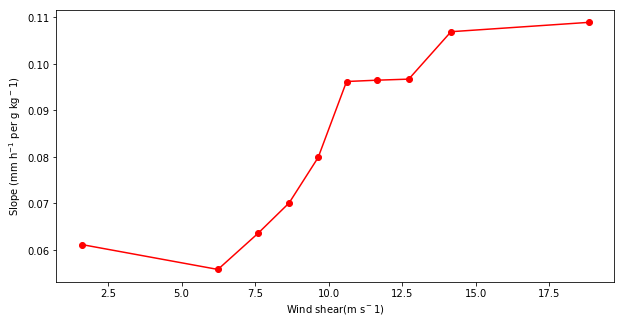

In [179]:
f = plt.figure(figsize=(10,5))
ax = f.add_subplot(111)
ax.plot(qmean,corr, 'ro-')
ax.set_xlabel('Wind shear(m s$^-1$)')
ax.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')

In [180]:
def hist2d_bar(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(5,10))
    text = ['(a)', '(b)', '(c)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(3,1,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(313)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black')
    ax4.set_xlabel('650-925hPa wind shear (m s$^{-1}$)')
    ax4.set_ylabel('Probability rainfall > 55mm h$^{-1}$ (%)')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('Slope (mm h$^{-1}$ per g kg$^-1$)')
    


    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.97), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.02, 0.64), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.315), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
#plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly.png')

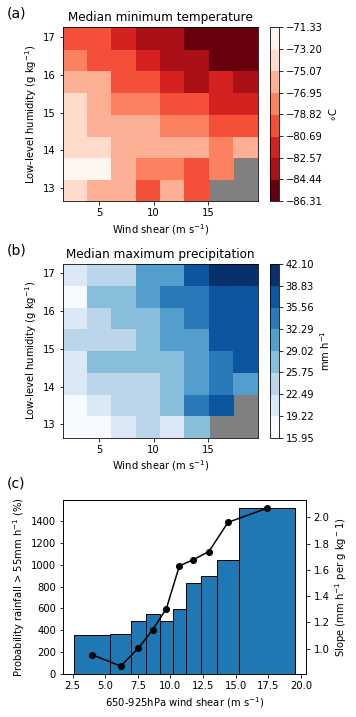

In [181]:
data_list = [tmin_dic, prcp_dic]
hist2d_bar(data_list, bar_dic, slope_dic, valid=False)

In [182]:
obs_gpm.keys()

Index(['area', 'lat', 'lon', 'month', 'prcp', 'q650', 'q925', 'shear', 't650',
       't925', 'theta_e', 'tmean', 'tmin', 'u650', 'u925'],
      dtype='object')

pears (0.18840448560857145, 1.3864997440242262e-115)


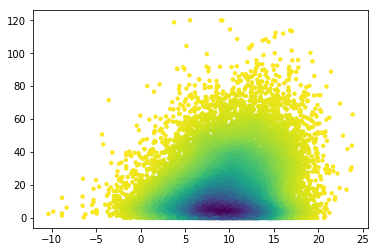

In [183]:
dat = obs_gpm
data1, r1 = density_plot(dat.shear, dat.prcp, dat.q925)

plt.scatter(dat.shear, dat.prcp, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r

In [184]:
rainlist = []
for rain in OBS['p']:
    
    rainlist.extend(rain.flat)

In [185]:
len(rainlist)
rain = np.array(rainlist)

In [186]:
np.percentile(rain[rain>1],95)

22.52128280644234

In [187]:
np.percentile(obs_gpm.prcp[obs_gpm.prcp>1],95)

57.75760822868769

In [188]:
dQ = pkl.load(open(cnst.network_data + 'data/CLOVER/saves/deltaQ_plot.p',
                           'rb'))

In [189]:
dQ

{'deltaqy': array([ 0.0501999 ,  0.03189941, -0.040171  ,  0.10085453,  0.19249202,
         0.3573268 ,  0.629571  ,  0.51972616,  0.45858485,  0.6206908 ],
       dtype=float32),
 'tminstd': array([-68.48999023, -69.314991  , -70.38499832, -70.79998779,
        -71.02999878, -71.72999573, -72.54499054, -73.13749695,
        -73.68998718, -74.25999451]),
 'tminx': array([ 5.566946,  7.212179,  8.460169,  9.554464, 10.559965, 11.570615,
        12.676903, 13.901707, 15.342691, 17.408857], dtype=float32),
 'tminy': array([-72.96999359, -74.12499237, -74.80499268, -75.18998718,
        -75.72999573, -76.48999023, -77.38999939, -78.33999634,
        -78.81999207, -79.39499664])}

In [190]:
x = np.array(dQ['tminx'])
corr_all = np.array(dQ['deltaqy'])

qcorr_all = np.array(dQ['tminy'])
qcorr_all_std = np.array(dQ['tminstd'])

In [194]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
        plt.plot(9.9,15.1,'ko')
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.bar(bar['xtick'], np.array(bar['ytick'])*100, bar['width'], align='edge', ec='black', color='lightblue')
    ax4.set_xlabel('Wind shear (m s$^{-1}$)')
    ax4.set_ylabel('%')
    
    ax5 = ax4.twinx()
    ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
    ax5.set_xlabel('Wind shear(m s$^-1$)')
    ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
    ax5.text(0.01,0.8,'Slope', color='k', transform=ax5.transAxes, fontsize=11)
    ax5.text(0.01,0.9,'Probability Rainfall > 55 mm h$^{-1}$', color='b', transform=ax5.transAxes, fontsize=11)
    
    ax6 = f.add_subplot(223)
    ax6.plot(x,corr_all, 'k-o', label='${\Delta}$q925')
    ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='b', alpha=0.05)
    ax7 = ax6.twinx()
    ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
    ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
    #ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
    ax7.set_ylim(-85,-70)
    ax7.set_ylim(ax7.get_ylim()[::-1])
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('g kg$^{-1}$')
    ax7.set_ylabel(r'${\circ}$C')
    ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
    ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_deltaQ.png')

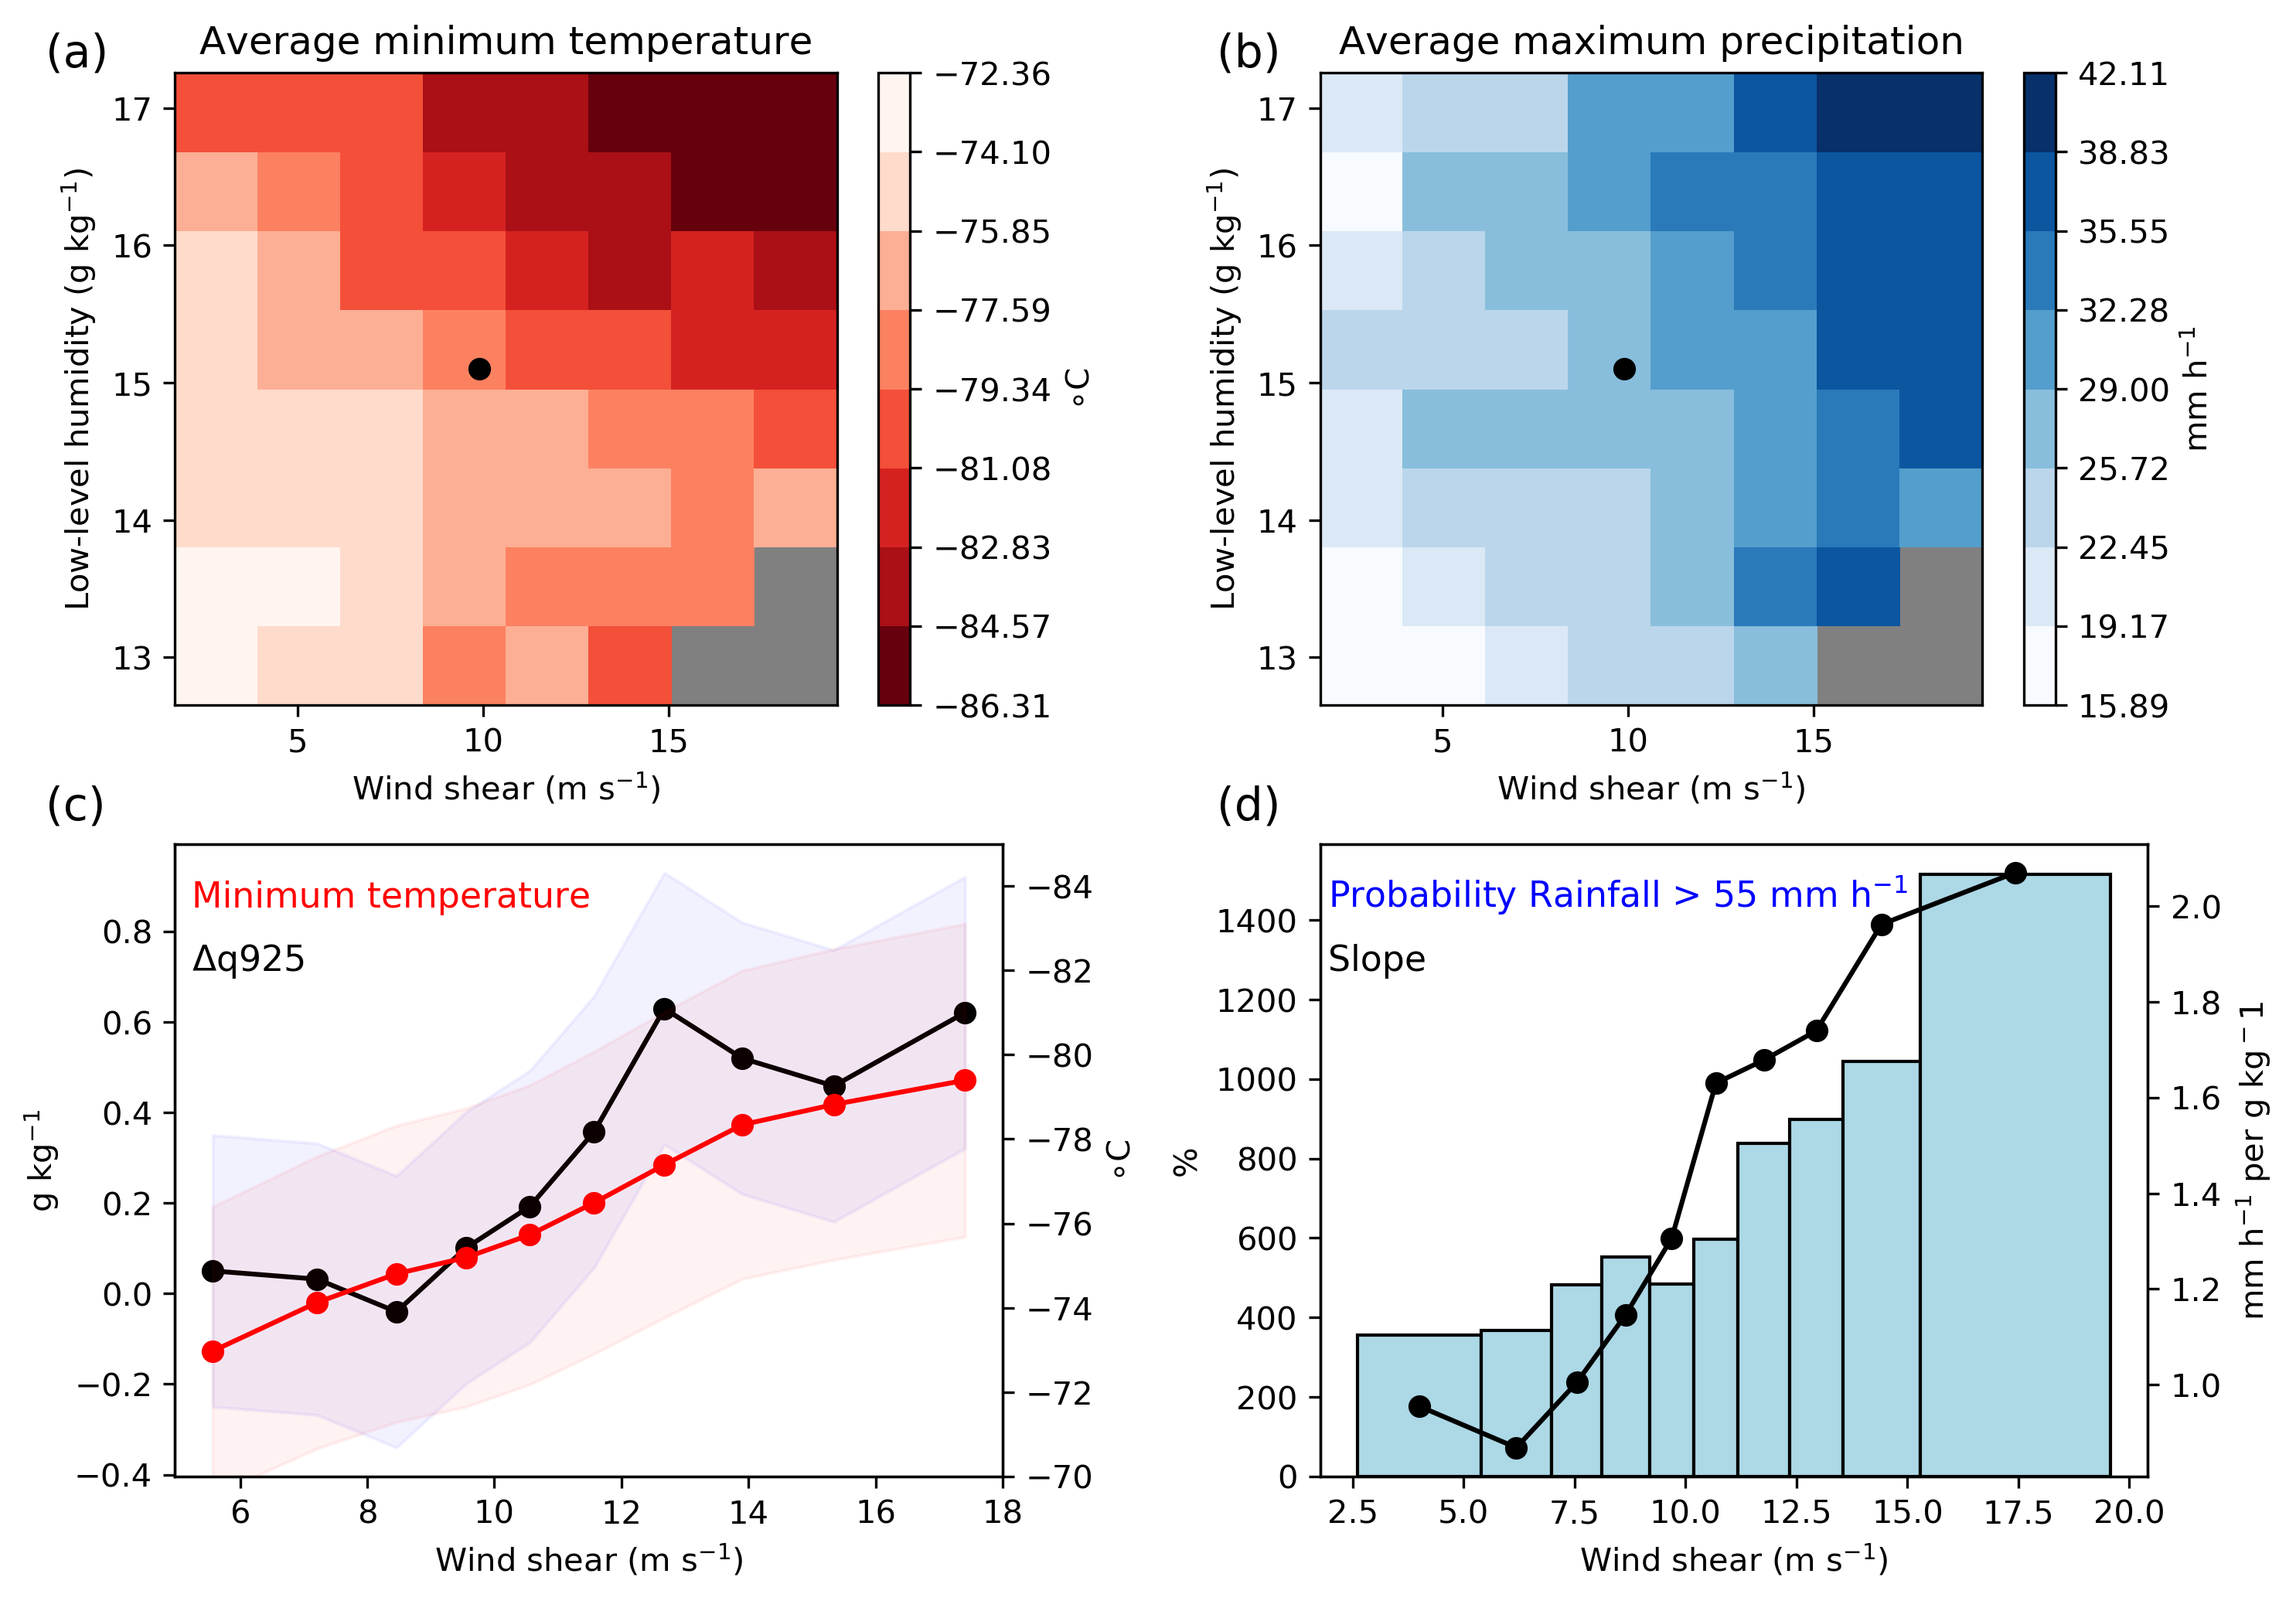

In [195]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

In [198]:
def hist2d_deltaQ(data, box1, box2, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,7), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<10] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
        plt.plot(10.2,15.2,'ko')
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    ax4 = f.add_subplot(224)
    ax4.set_xlabel('Low-level humidity (g kg$^{-1}$)')
    ax4.set_ylabel('Average max. precipitation (mm h$^{-1}$)')
    
    bp = ax4.boxplot(box2[0], labels=box2[1], whis=3, patch_artist=True)
    for patch in (bp['boxes']):
        patch.set(facecolor='aliceblue')   
    
    ax6 = f.add_subplot(223)
    bp2 = ax6.boxplot(box1[0], labels=box1[1], whis=3, patch_artist=True)
    for patch in (bp2['boxes']):
        patch.set(facecolor='aliceblue')  
        
    ax6.set_xlabel('Wind shear (m s$^{-1}$)')
    ax6.set_ylabel('Average max. precipitation (mm h$^{-1}$)')
#     ax6.text(0.02,0.8,'${\Delta}$q925', color='k', transform=ax6.transAxes, fontsize=11)
#     ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[2], xy=(0.02, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[3], xy=(0.53, 0.48), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/fig_2dhist_obsOnly_boxplot.png')

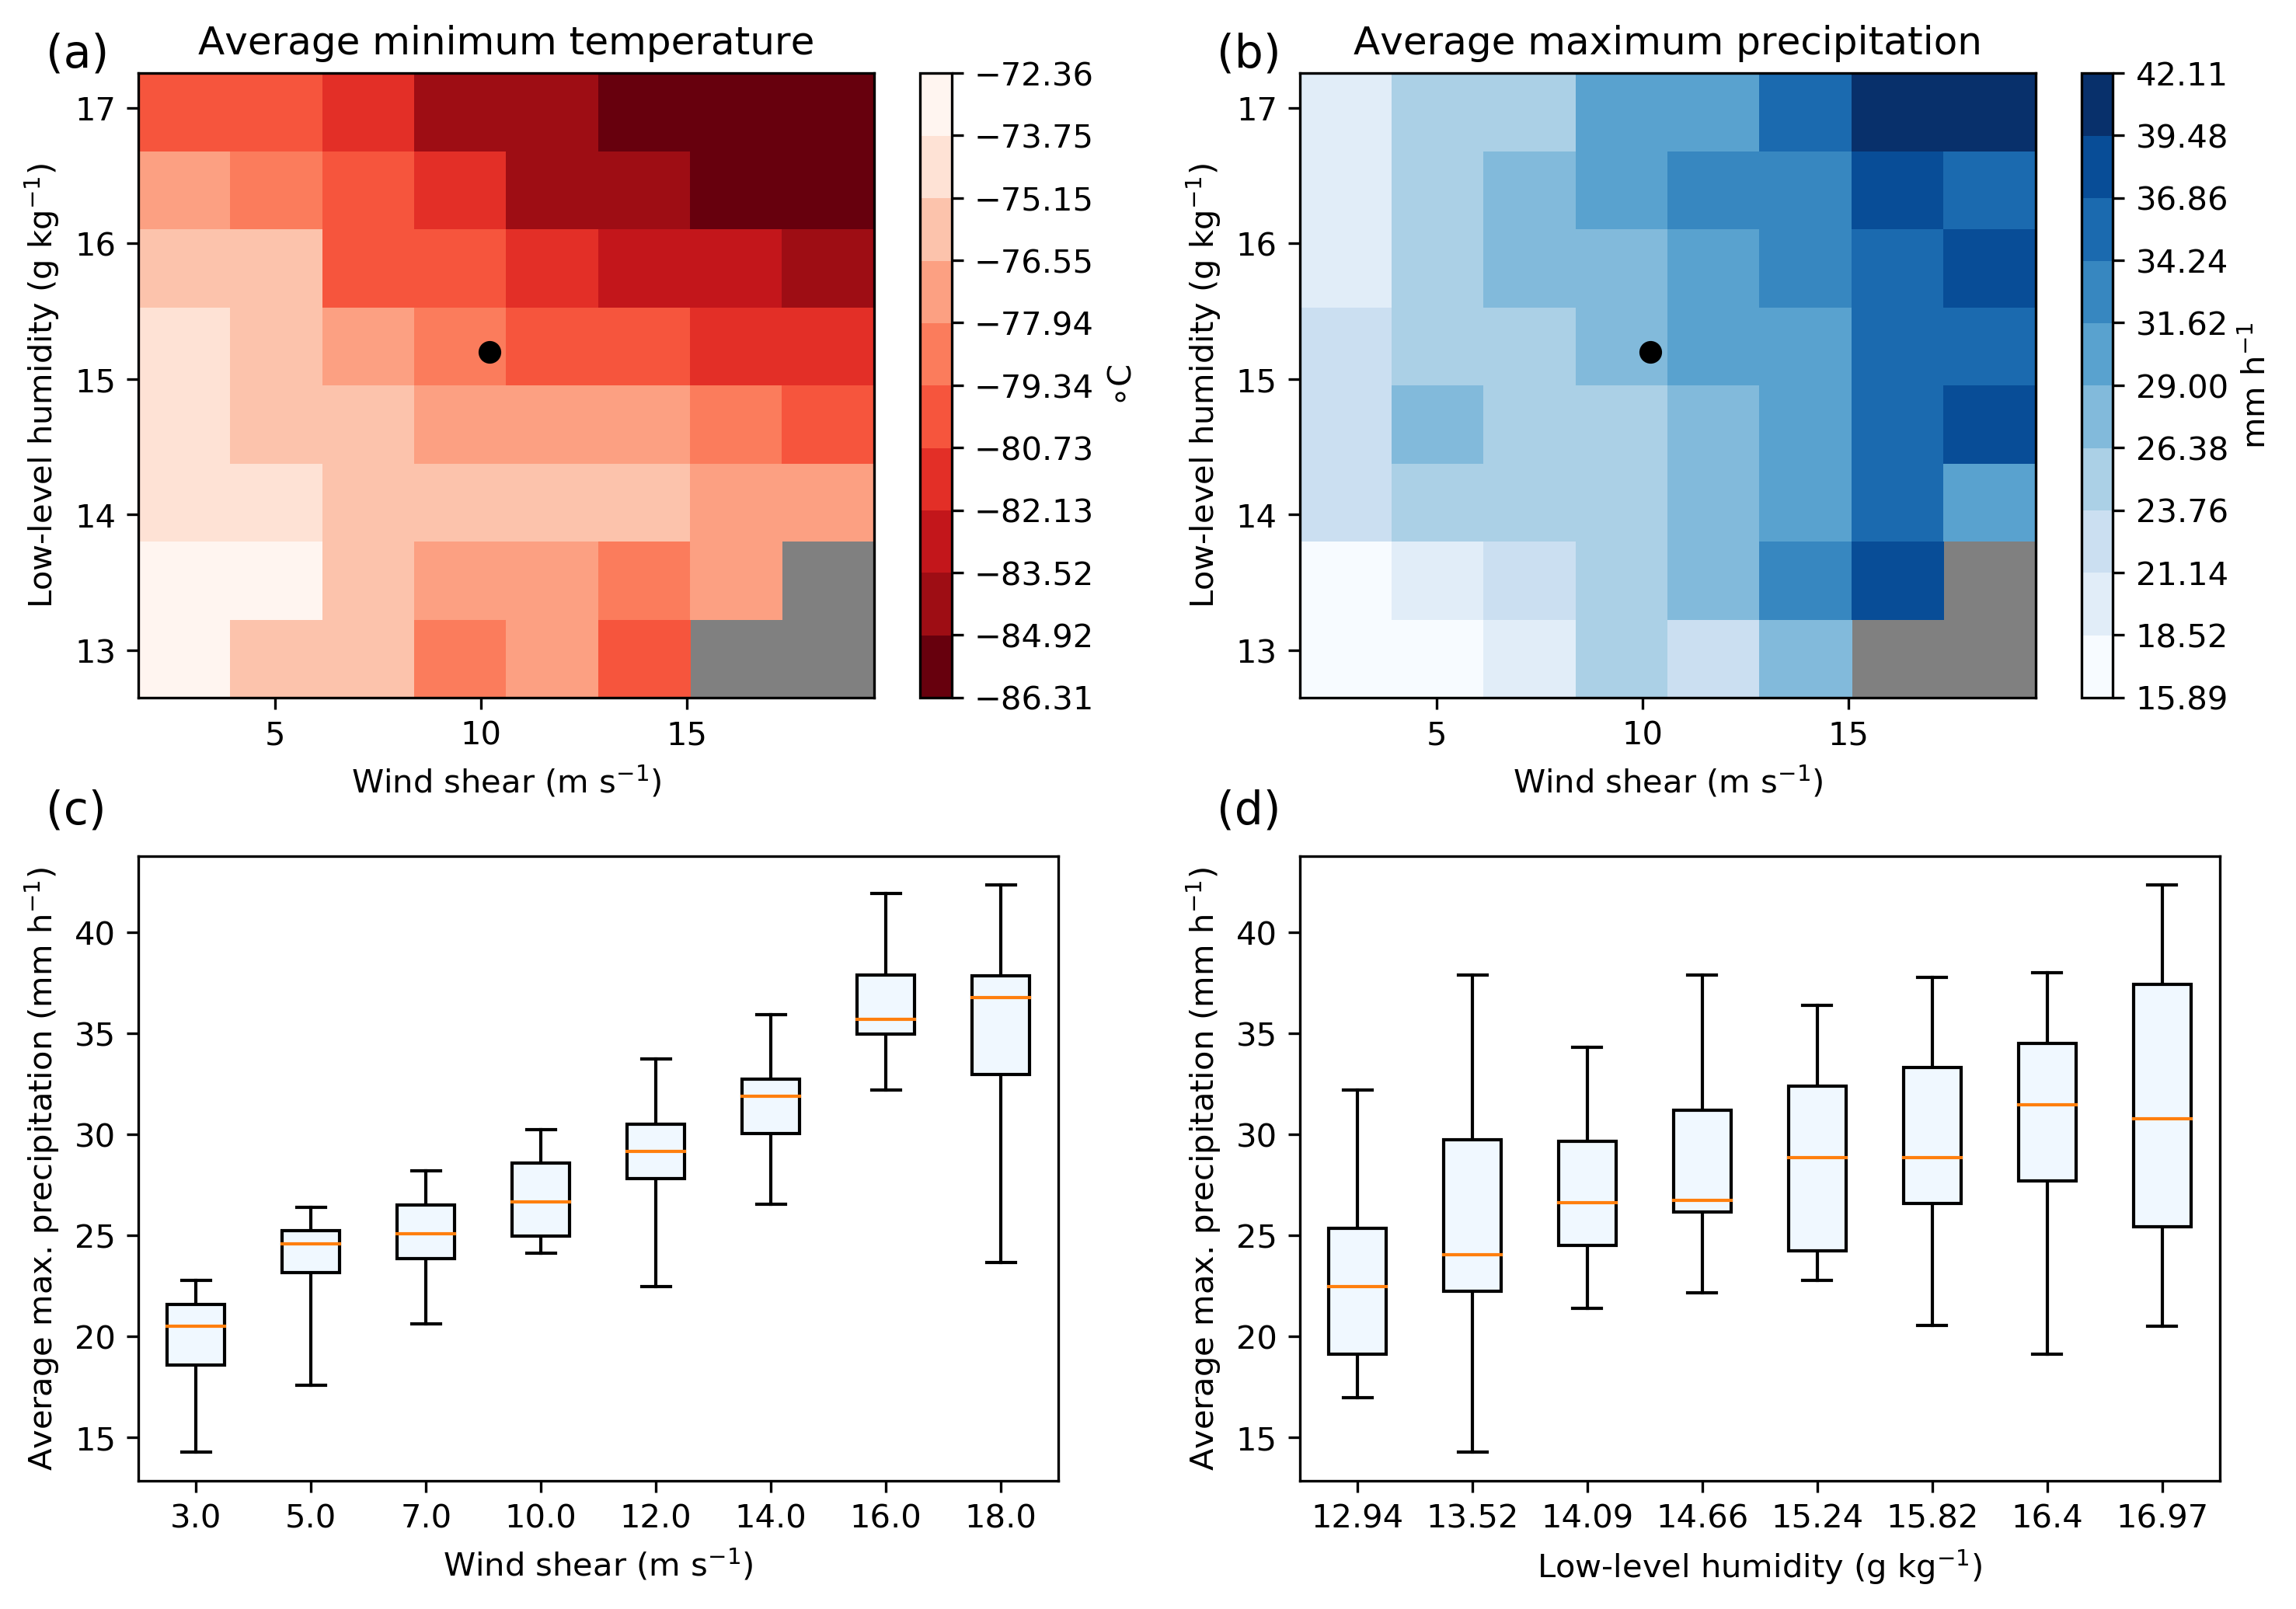

In [199]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, box1, box2, valid=False)

In [817]:
def hist2d_deltaQ(data, bar, slope, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(10,4), dpi=300)
    text = ['(a)', '(b)', '(c)', '(d)']
    for i, dat in enumerate(data):
        ax = f.add_subplot(1,2,i+1)
        if i>0:
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap=cmap)
        if valid:
            
            dat['data'][dat['valid']<40] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        #plt.text(0.03,0.85, text[i], transform=ax.transAxes, fontsize=14)

        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        ax.set_facecolor('grey')
        #ax.set_ylim(13,17.5)
        
    plt.tight_layout() 
    plt.annotate(text[0], xy=(0.02, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    plt.annotate(text[1], xy=(0.53, 0.93), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points')
    
 #   plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist.png')
        
 

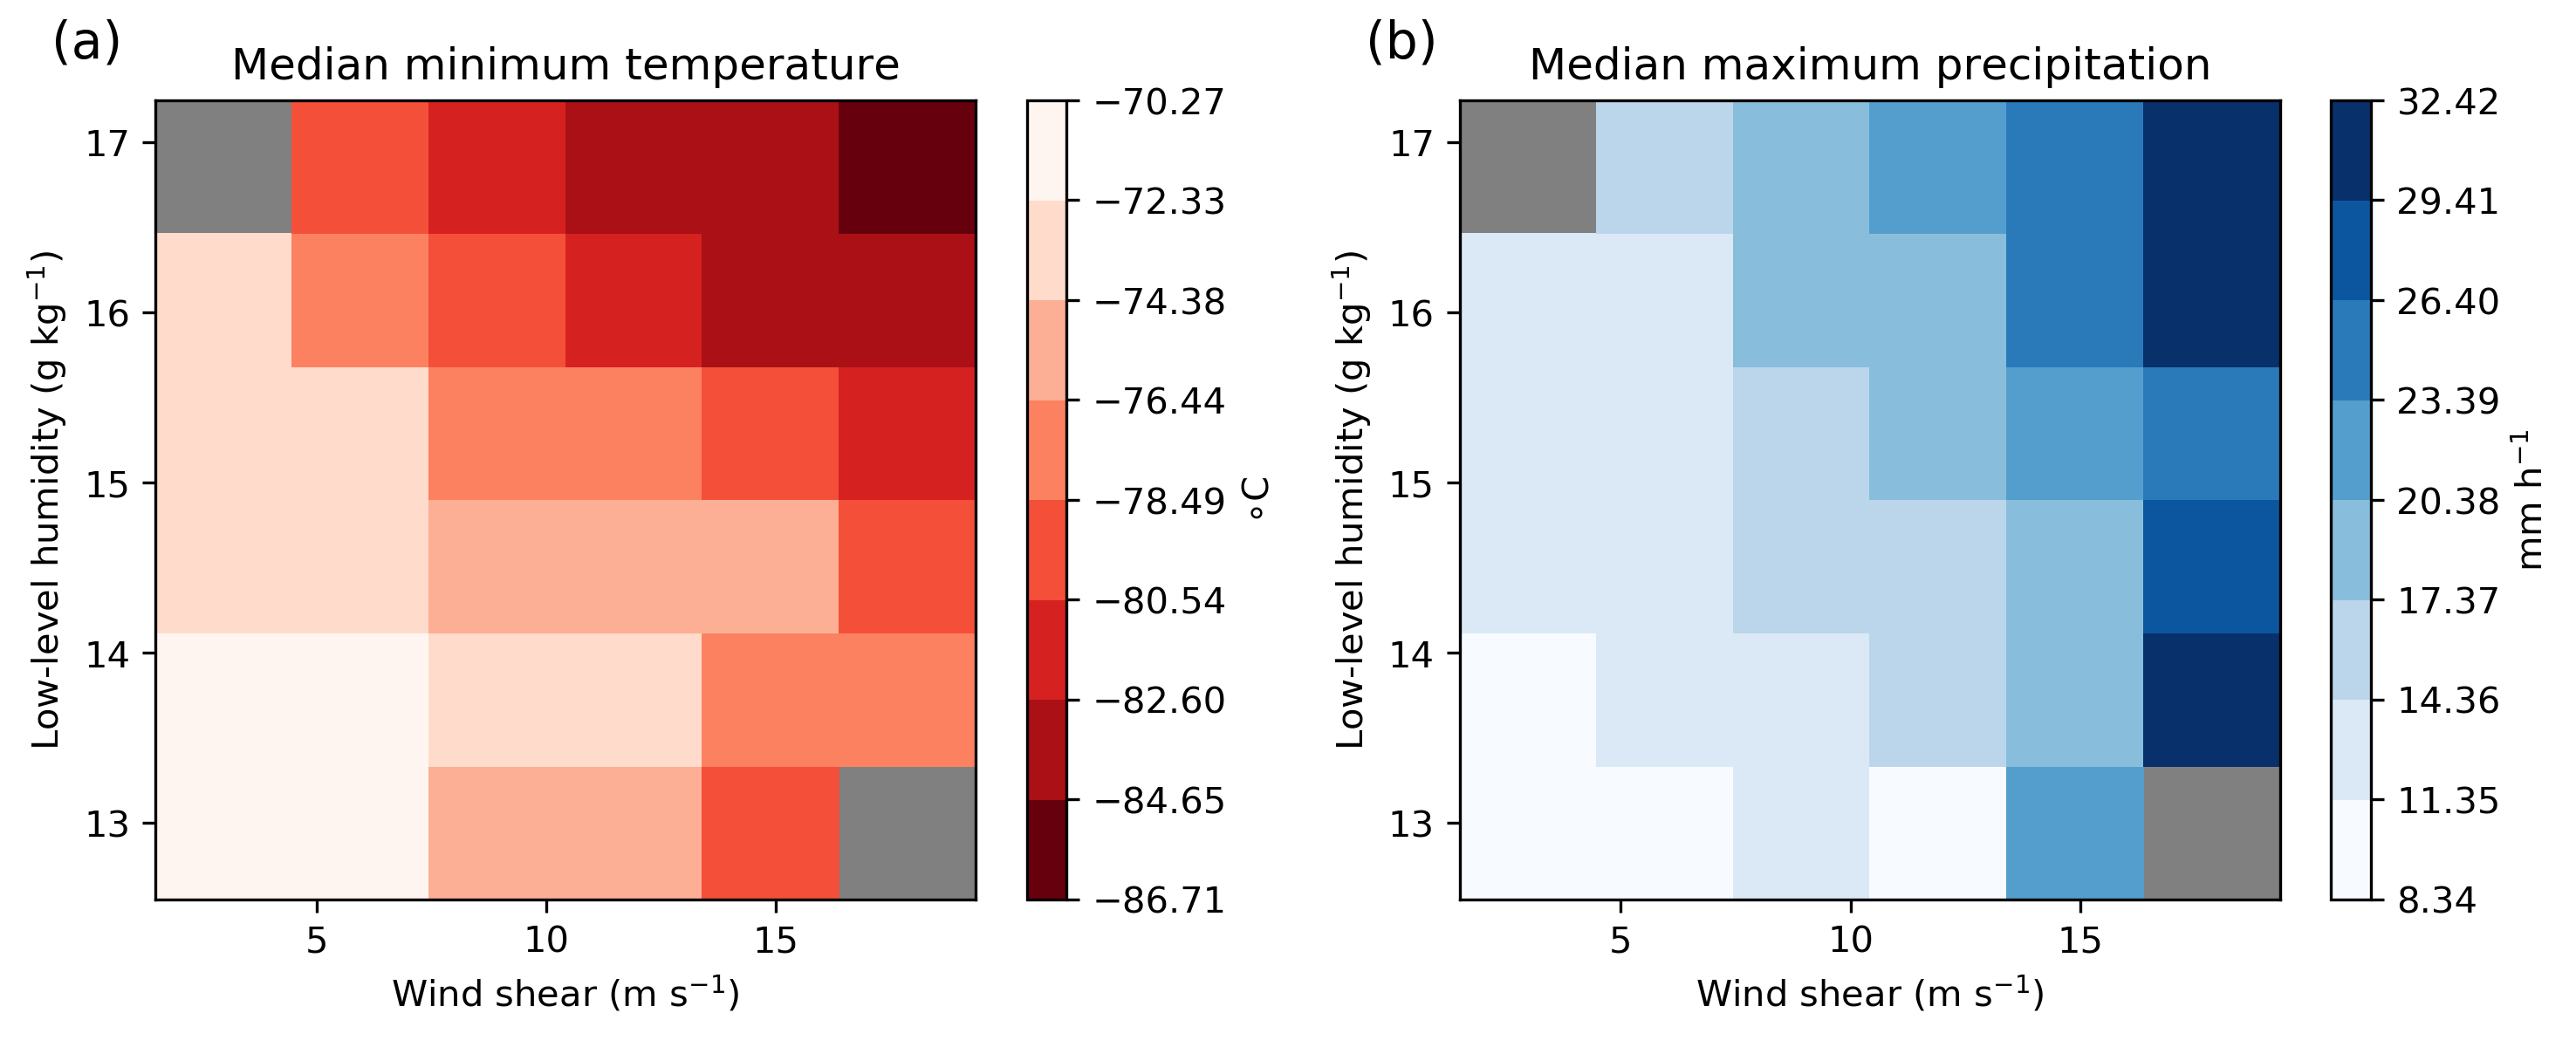

In [818]:
data_list = [tmin_dic, prcp_dic]
hist2d_deltaQ(data_list, bar_dic, slope_dic, valid=False)

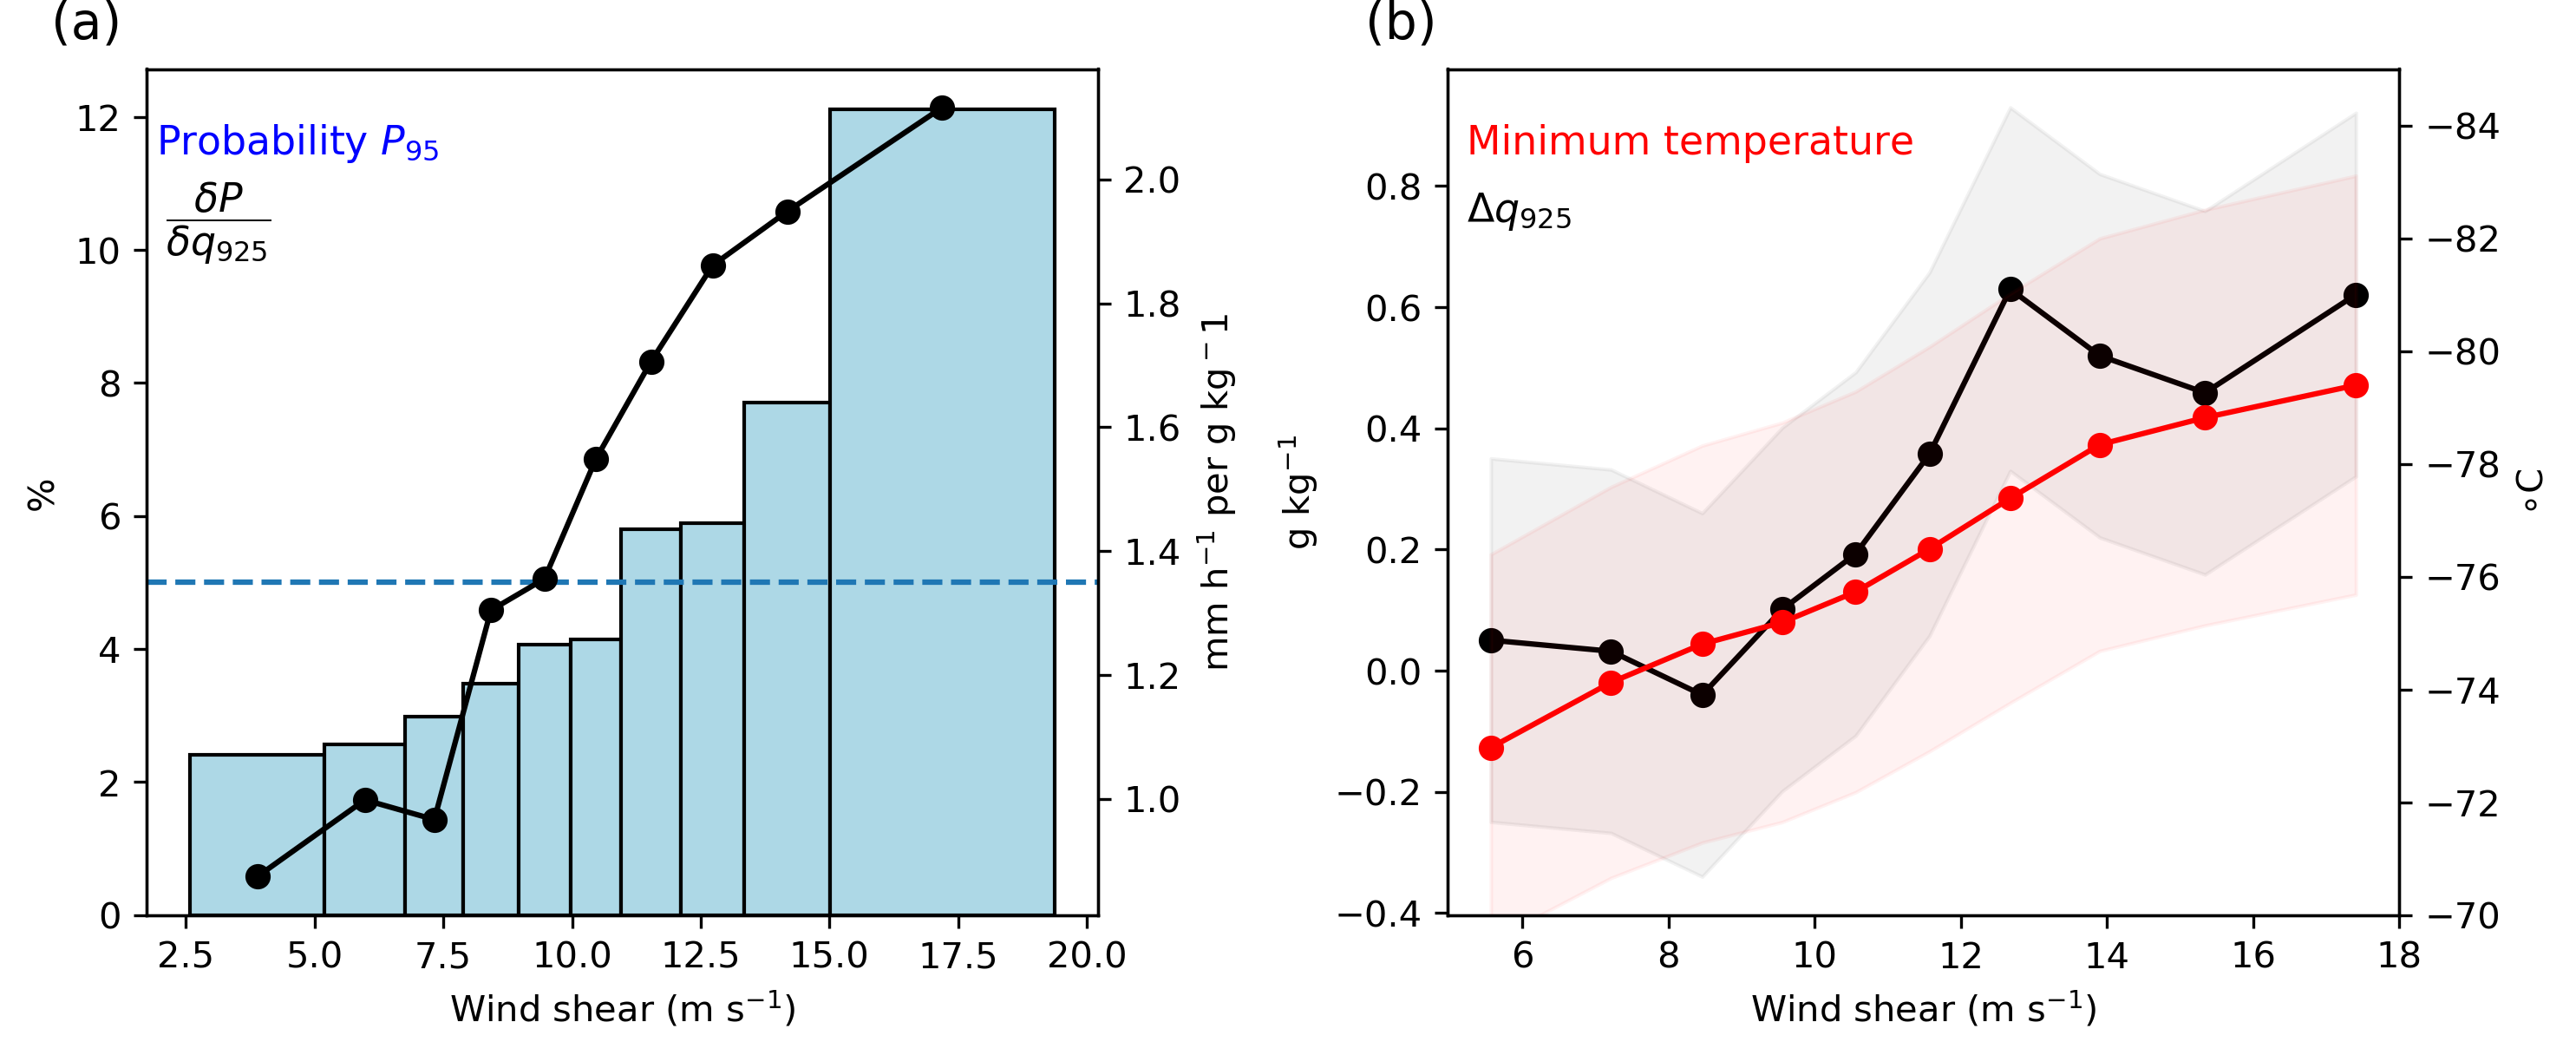

In [843]:
bar = bar_dic
slope = slope_dic

f = plt.figure(figsize=(10,4), dpi=300)
text = ['(a)', '(b)', '(a)', '(b)']
ax4 = f.add_subplot(121)
ax4.bar(bar['xtick'], np.array(bar['ytick']), bar['width'], align='edge', ec='black', color='lightblue')
ax4.set_xlabel('Wind shear (m s$^{-1}$)')
ax4.set_ylabel('%')

ax5 = ax4.twinx()
ax5.plot(np.array(bar['xtick'])+np.array(bar['width'])/2,slope['ytick'], 'ko-') #np.array(bar['xtick'])+np.array(bar['width'])/2
ax5.set_xlabel('Wind shear(m s$^-1$)')
ax5.set_ylabel('mm h$^{-1}$ per g kg$^-1$')
ax4.axhline(5, linestyle='dashed')
ax5.text(0.02,0.81,r'$\dfrac{\delta P}{\delta q_{925}}$', color='k', transform=ax5.transAxes, fontsize=11)
ax5.text(0.01,0.9,'Probability $P_{95}$', color='b', transform=ax5.transAxes, fontsize=11)

ax6 = f.add_subplot(122)
ax6.plot(x,corr_all, 'k-o', label='${\Delta}q_{925}$')
ax6.fill_between(x,corr_all-0.3, corr_all+0.3, color='k', alpha=0.05)
ax7 = ax6.twinx()
ax7.plot(x,qcorr_all, 'ro-', label='Minimum T')
ax7.fill_between(x,qcorr_all-qcorr_all_std*0.05, qcorr_all+qcorr_all_std*0.05, color='r', alpha=0.05)
#ax1.errorbar(x, qcorr_all, yerr=qcorr_all_std*0.05, fmt='.k');
ax7.set_ylim(-85,-70)
ax7.set_ylim(ax7.get_ylim()[::-1])
ax6.set_xlabel('Wind shear (m s$^{-1}$)')
ax6.set_ylabel('g kg$^{-1}$')
ax7.set_ylabel(r'${\circ}$C')
ax6.text(0.02,0.82,'${\Delta}q_{925}$', color='k', transform=ax6.transAxes, fontsize=11)
ax6.text(0.02,0.9,'Minimum temperature', color='r', transform=ax6.transAxes, fontsize=11)

plt.tight_layout()
plt.annotate(text[2], xy=(0.02, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.annotate(text[3], xy=(0.53, 0.95), xytext=(0, 4), size=14, xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points')
plt.savefig(cnst.network_data + 'figs/CLOVER/paper1/2dHist_new.png')